In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import json
import h5py
from helper.general import *
from helper.plotting import *
plt.style.use('seaborn-colorblind')
%matplotlib inline
#  matplotlib.rcParams.update({'font.size': 16})

In [2]:
# Set colormap for different image types
cmap_img_type = {}
cmap_img_type['water'] = 'gray'
cmap_img_type['fat'] = 'gray'
cmap_img_type['silicone'] = 'gray'
cmap_img_type['fieldmap'] = 'magma'
cmap_img_type['fatFraction_percent'] = 'inferno'
cmap_img_type['r2starmap'] = 'plasma'

In [3]:
F = Fatmodel(modelname='Ren marrow')
fatmodel = {}
fatmodel['freqs_ppm'] = F.deshielding_ppm
fatmodel['relAmps'] = F.relamps_percent / 100
silicone_freq_ppm = - 4.9

## Processing

Processing for all 20 subjects was performed using the script ./scripts/processing.py

## Comparison of methods (field-map swaps) (Fig. 7)

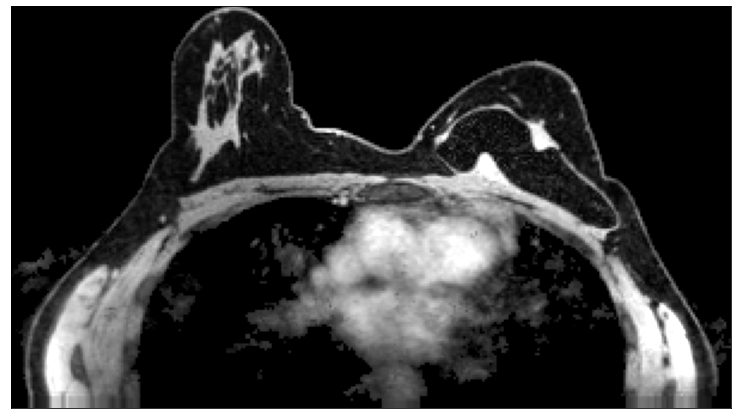

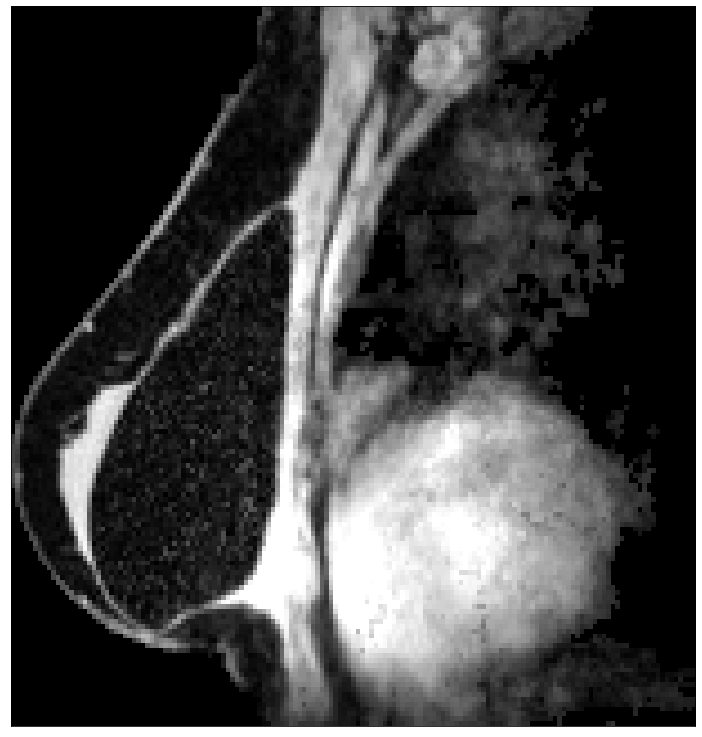

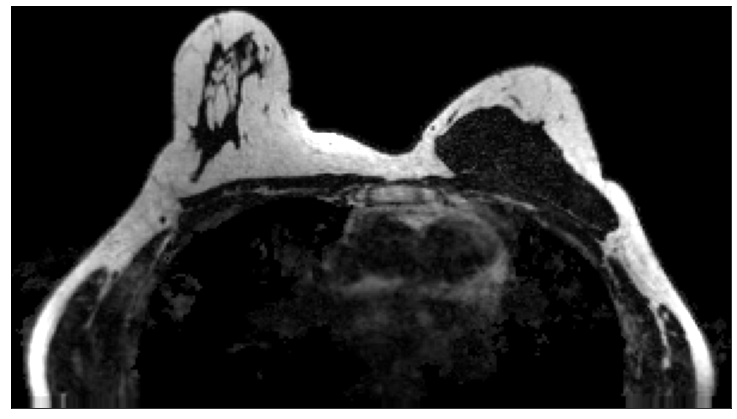

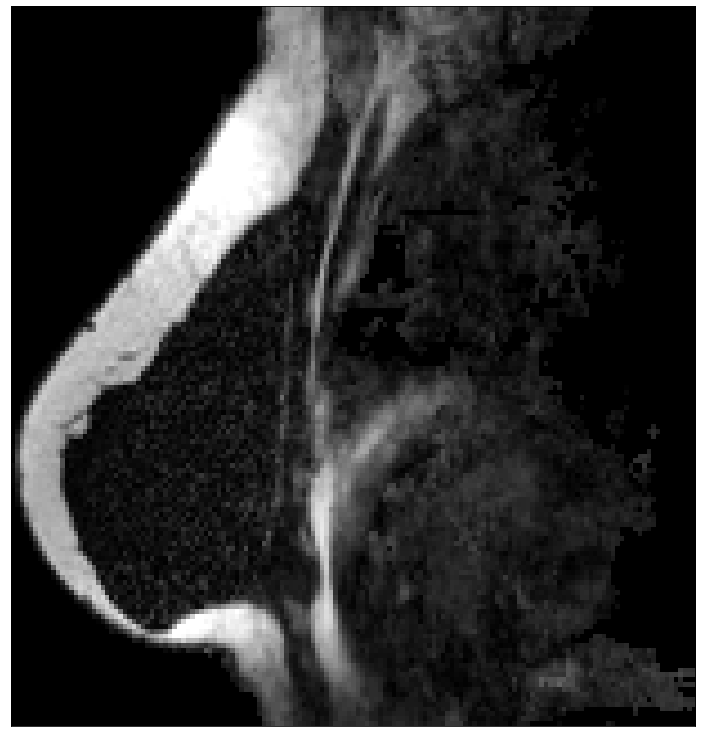

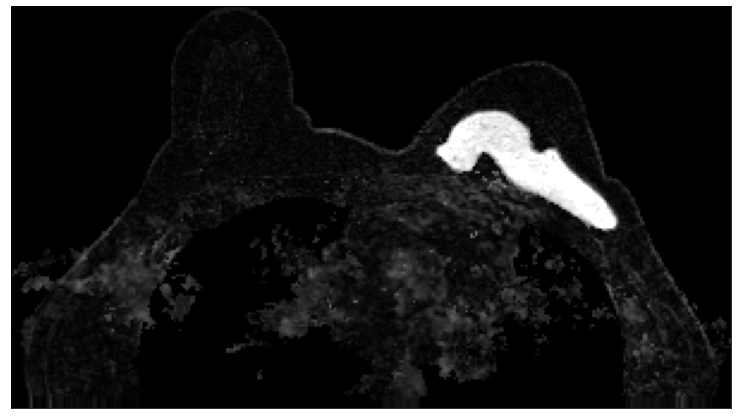

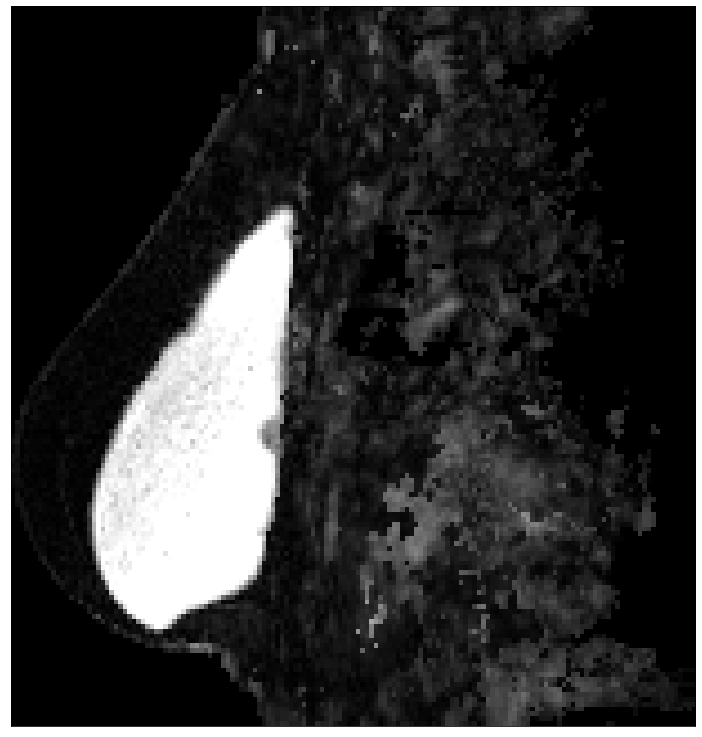

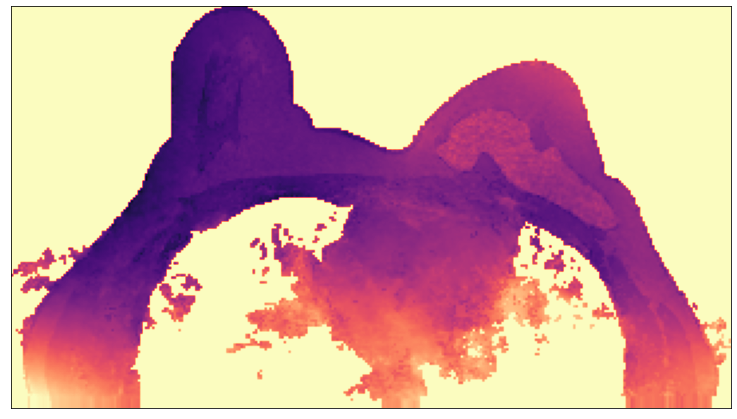

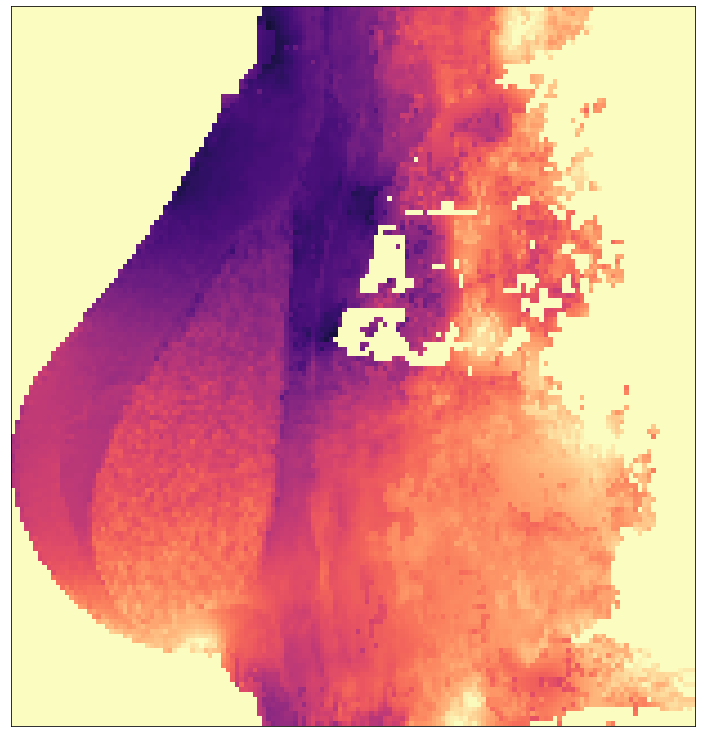

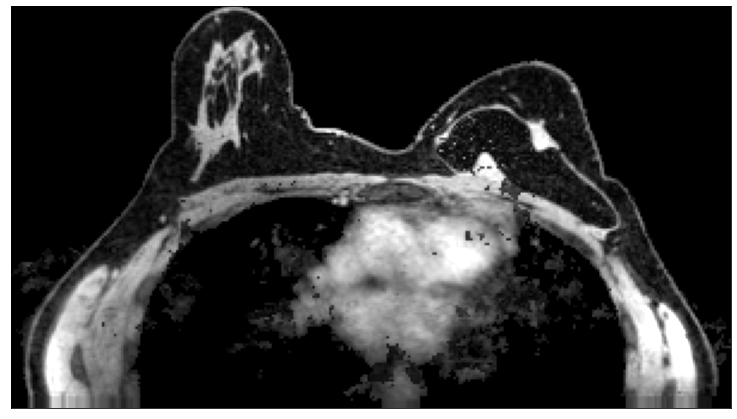

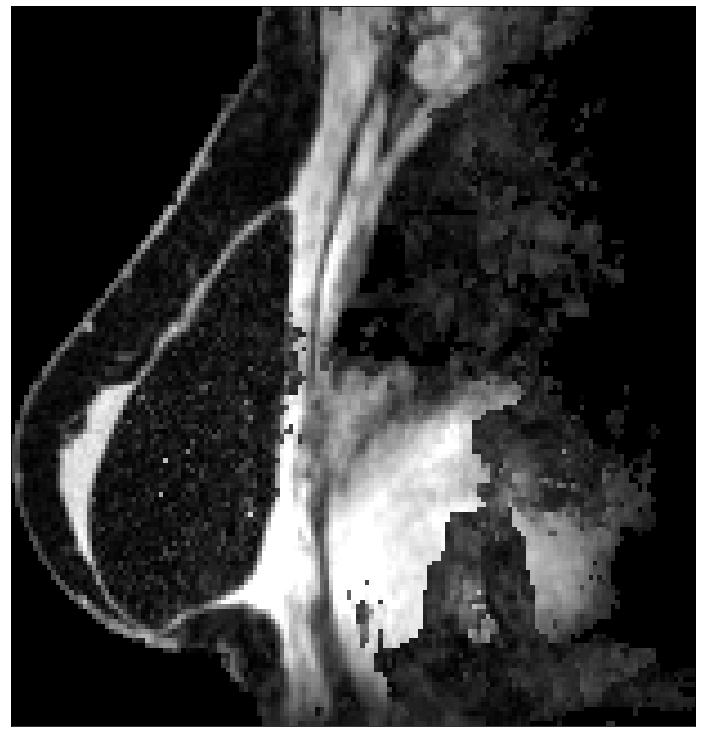

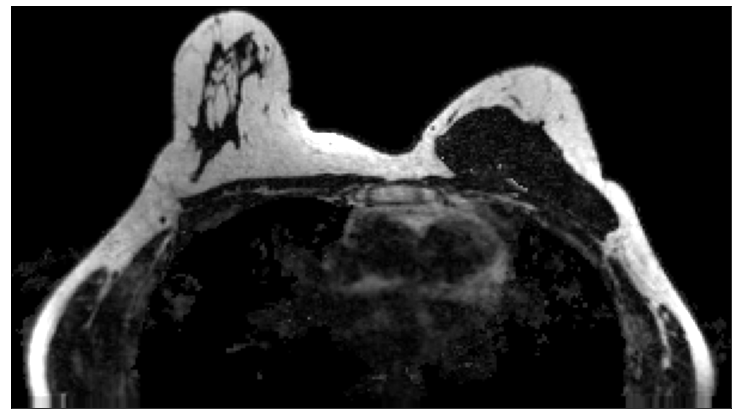

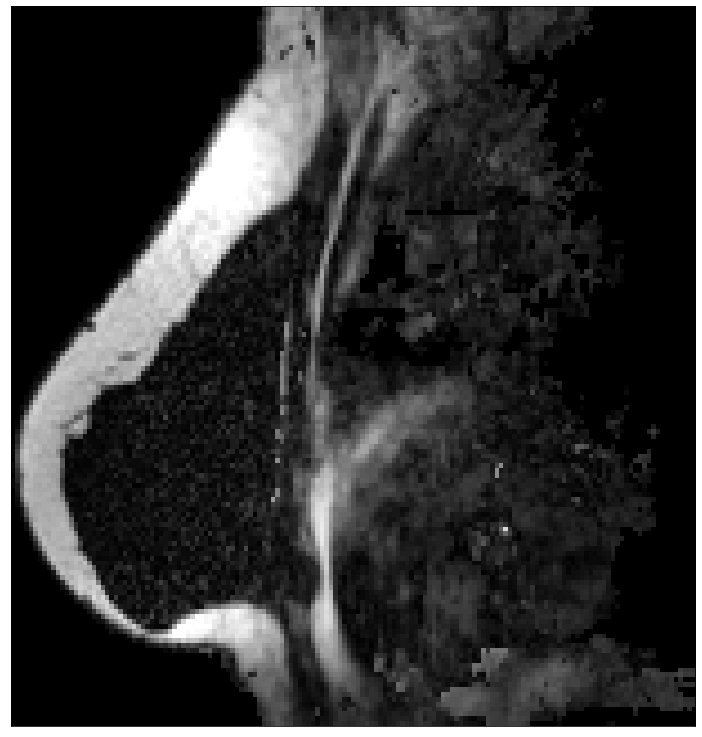

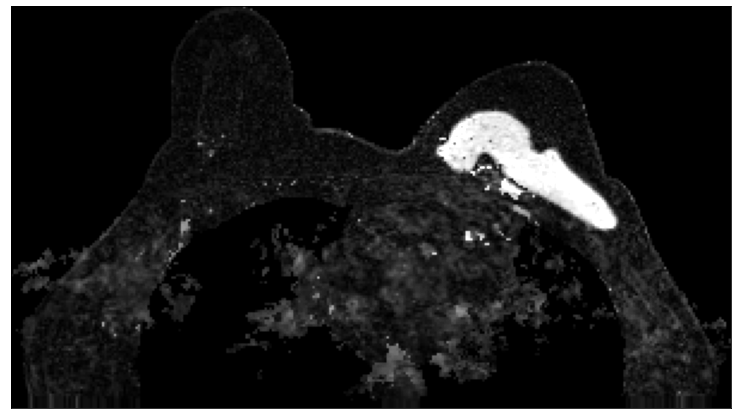

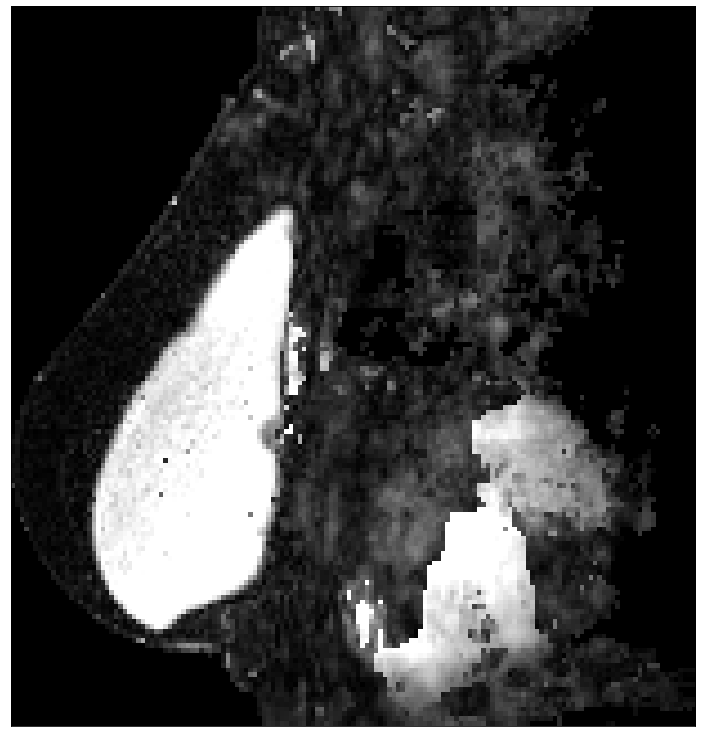

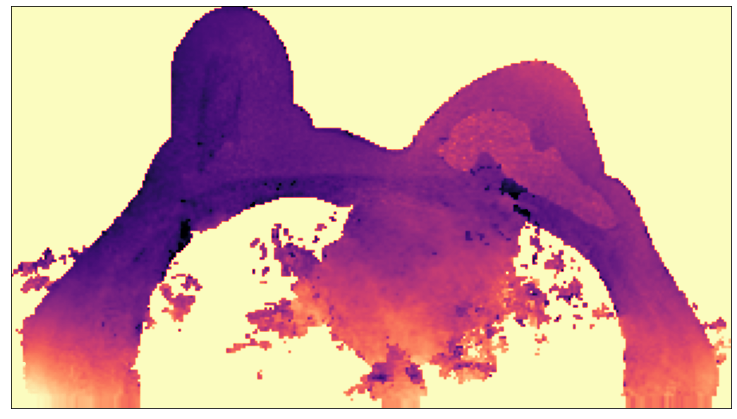

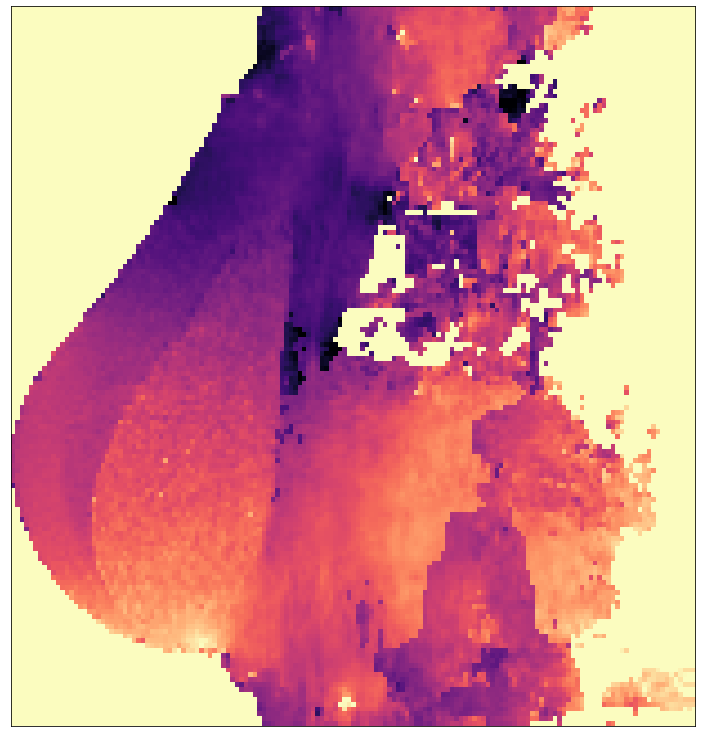

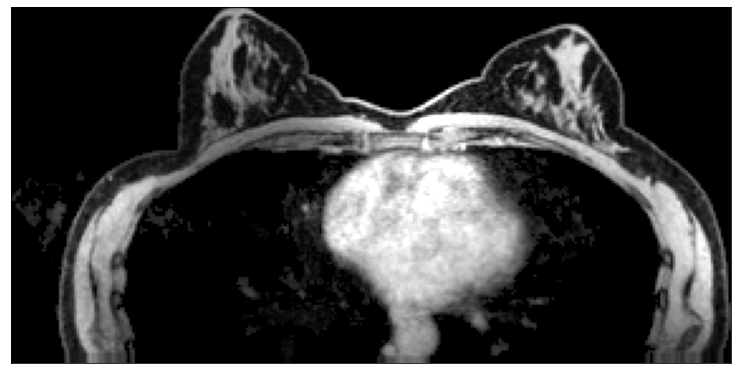

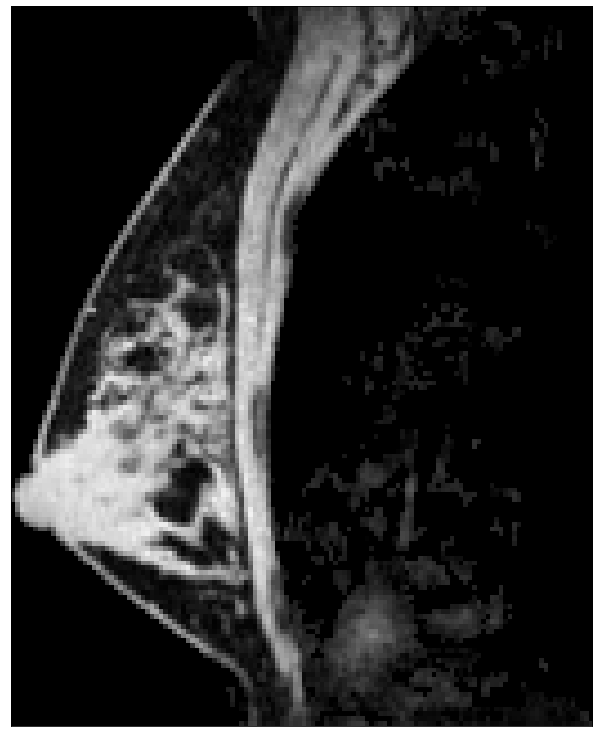

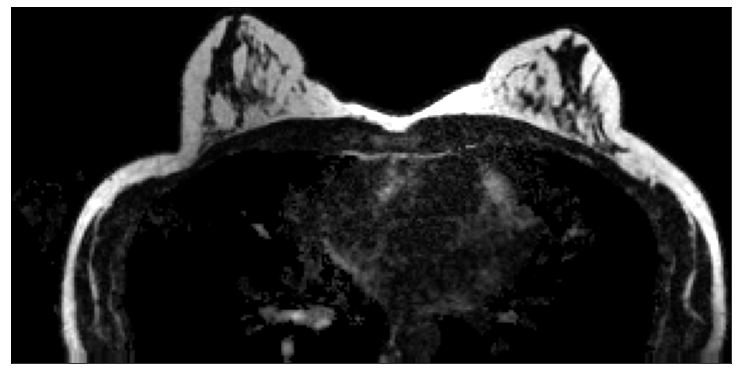

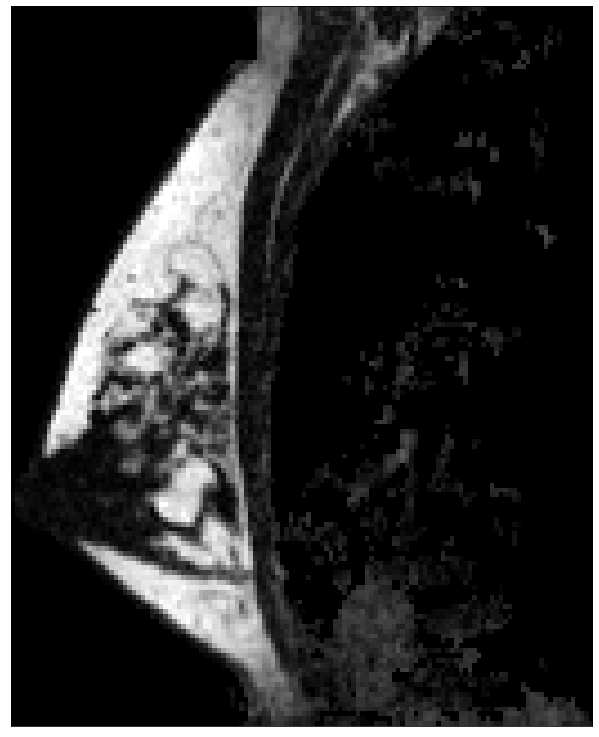

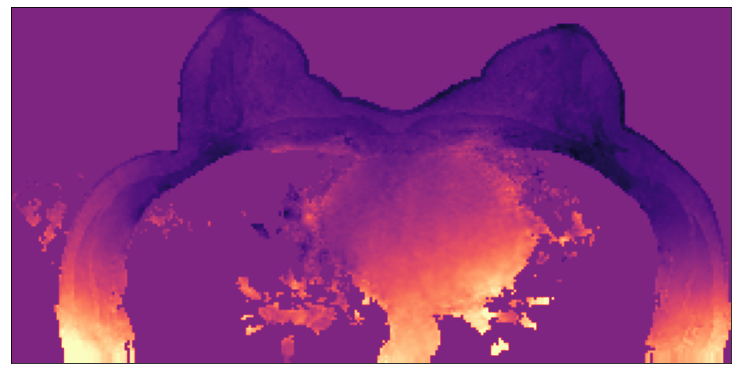

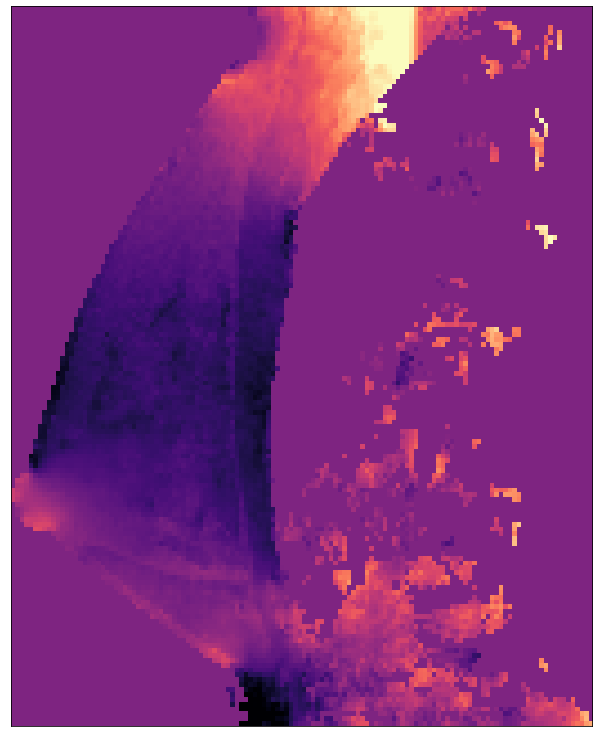

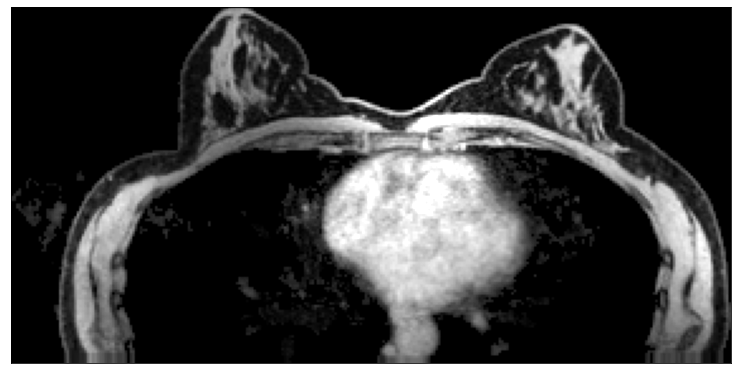

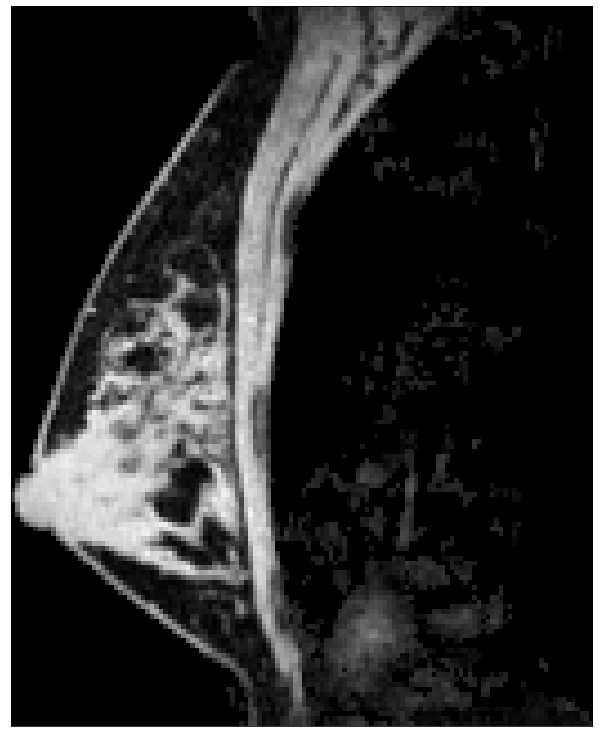

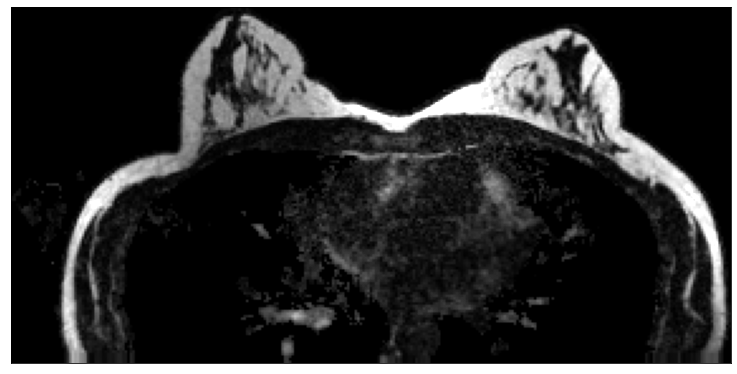

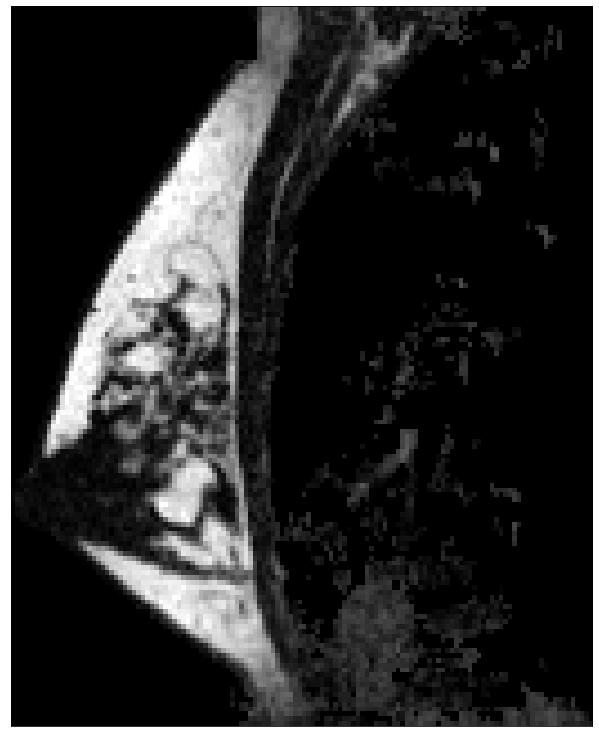

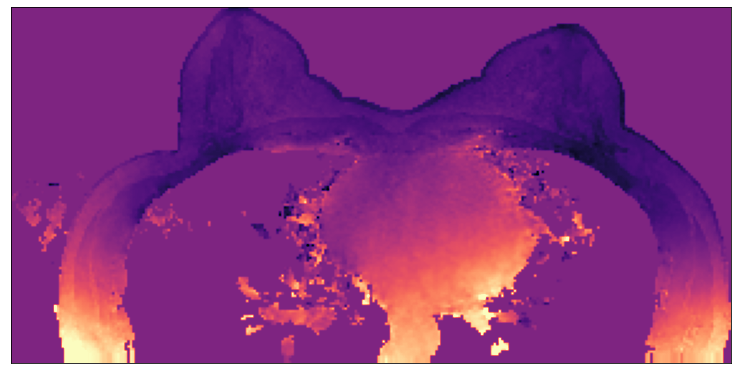

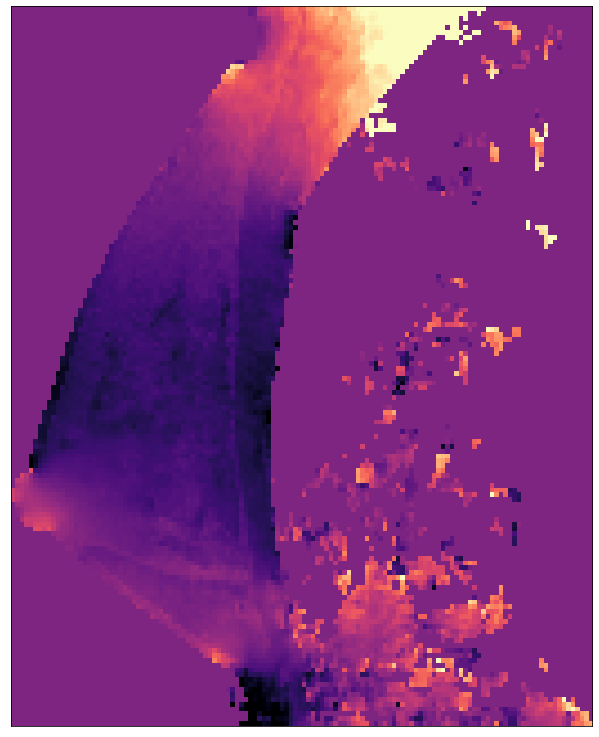

In [7]:
%matplotlib inline
fig_name = 'invivo_fieldmap'
os.makedirs(f'./figures/{fig_name}', exist_ok=True)

filenames = []
for subject in ['6S', '10']:
    source = h5py.File(f'./data/invivo/invivo_{subject}.h5', 'r')
    processed = h5py.File(f'./data/invivo/processed_workstation/processed_{subject}.h5', 'r')
    for echoes_number in ['4 echoes']:
        num_echoes = int(echoes_number[0])
        mask = get_tissueMaskFilled(source['multiecho'][..., :num_echoes], 10)
        for method in ['breast', 'single-res']:
            for img_type in ['water', 'fat', 'silicone', 'fieldmap']:
                if subject == '6S':
                    limits  = [-650, 0]
                    position_3d = [75, 222, 106]
                elif subject == '10':
                    if img_type == 'silicone':
                        continue
                    limits  = [-200, 350]
                    position_3d = [56, 233, 106]
                img = np.array(processed[echoes_number][method][img_type])
                img[~mask] = 0
                voxelsize = source['multiecho'].attrs['voxelSize_mm']
                filename = f'invivo_{echoes_number[0]}_echoes_{subject}__{method}_{img_type}'
                if img_type != 'fieldmap':
                    img = np.abs(img)
                    limits = None #[0,  np.percentile(img, 99)]
                    
                plot_images(img, cmap_img_type[img_type], ['axial','sagittal'], voxelsize, position_3d, limits,
                            filename=filename, fig_name=fig_name)

## Comparison of methods (processing time) (Fig. 8)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


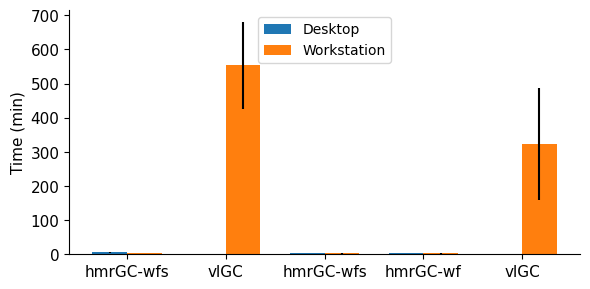

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


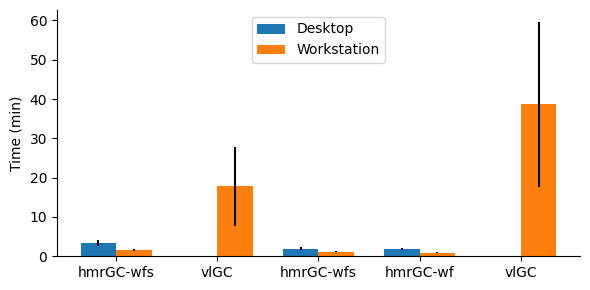

In [10]:
tags = ['silicone', 'no silicone']
devices = ['iMac', 'workstation']

plt.rcParams.update({'font.size': 11})
processing_times = {}
for tag in tags:
    processing_times[tag] = {}
    for device in devices:
        processing_times[tag][device] = {}
        for num_echoes in ['4 echoes', '6 echoes']:
            processing_times[tag][device][num_echoes] = {}
            for method in ['breast', 'multi-res', 'single-res']:
                processing_times[tag][device][num_echoes][method] = []
                
for device in devices:
    for root, dirs, files in os.walk(f'./data/invivo/processed_{device}/'):
        for file in files:
            if file[-2:] == 'h5':
                if file[-4] == 'S':
                    tag = 'silicone'
                else:
                    tag = 'no silicone'
                    
                processing = h5py.File(f'./data/invivo/processed_{device}/{file}', 'r')
                for num_echoes in processing.keys():
                    for method in processing[num_echoes].keys():
                        processing_times[tag][device][num_echoes][method].append(
                            processing[num_echoes][method].attrs['processing time'])  

os.makedirs('./figures/invivo_speed', exist_ok=True)
plot_performance(processing_times, '6 echoes', fig_name='invivo_speed')
plot_performance(processing_times, '4 echoes', fig_name='invivo_speed')

## In vivo separation (Fig. 9)

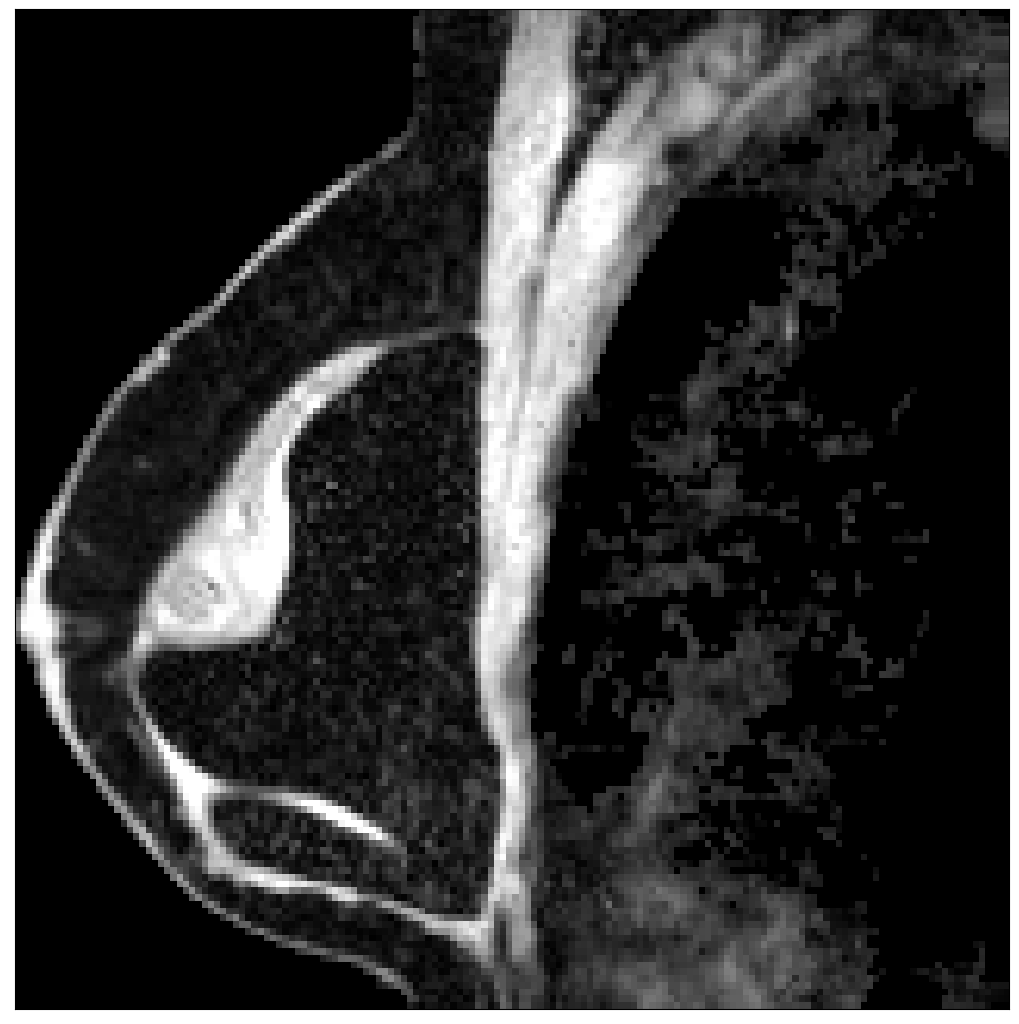

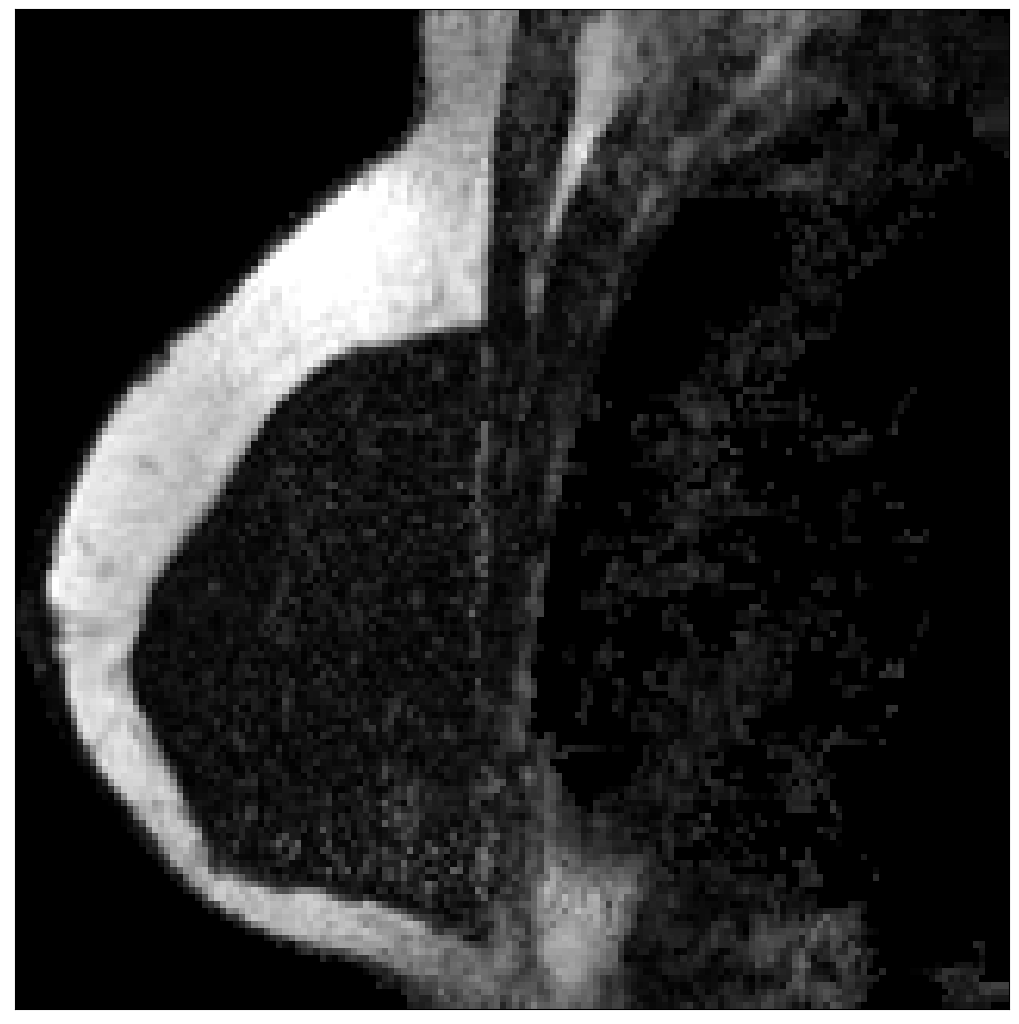

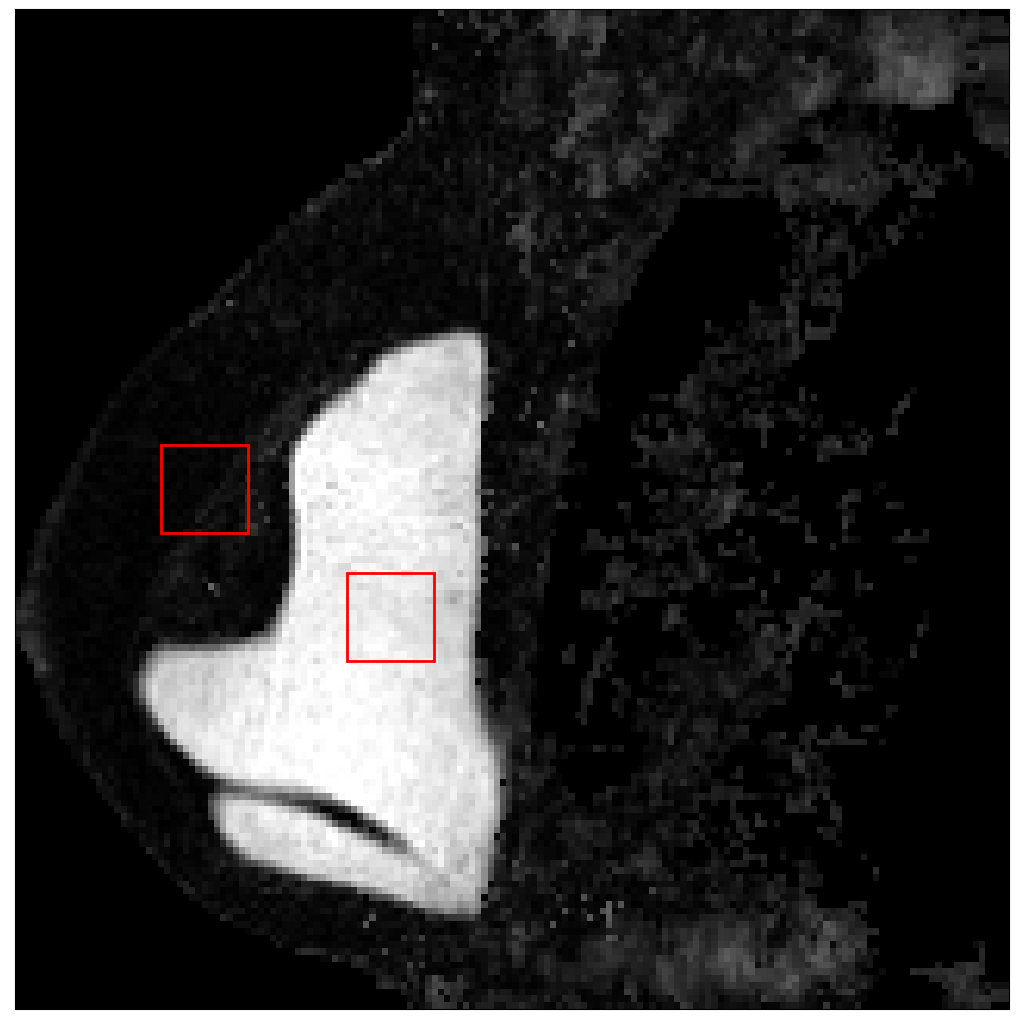

[(1627.8766, 69.25142), (63.253986, 45.300713)]
S/S0: 25.735557556152344


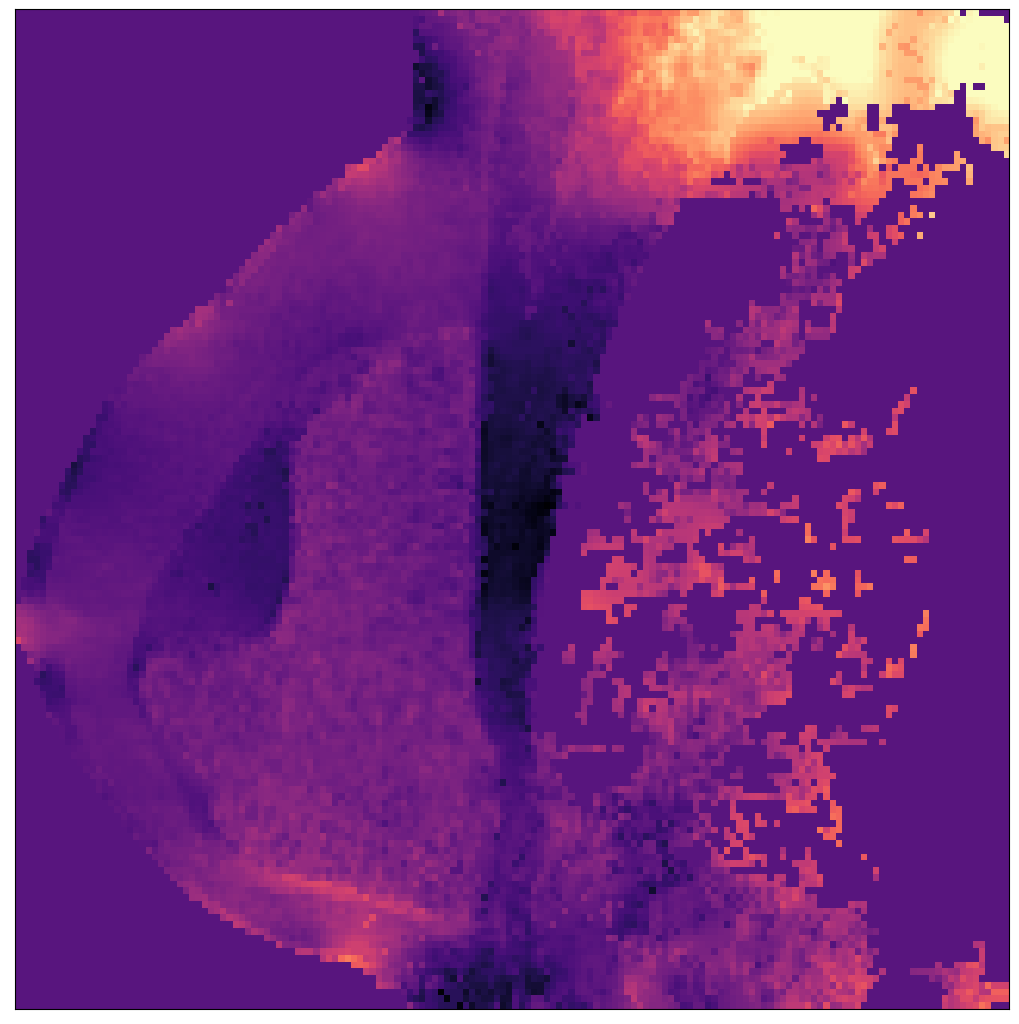

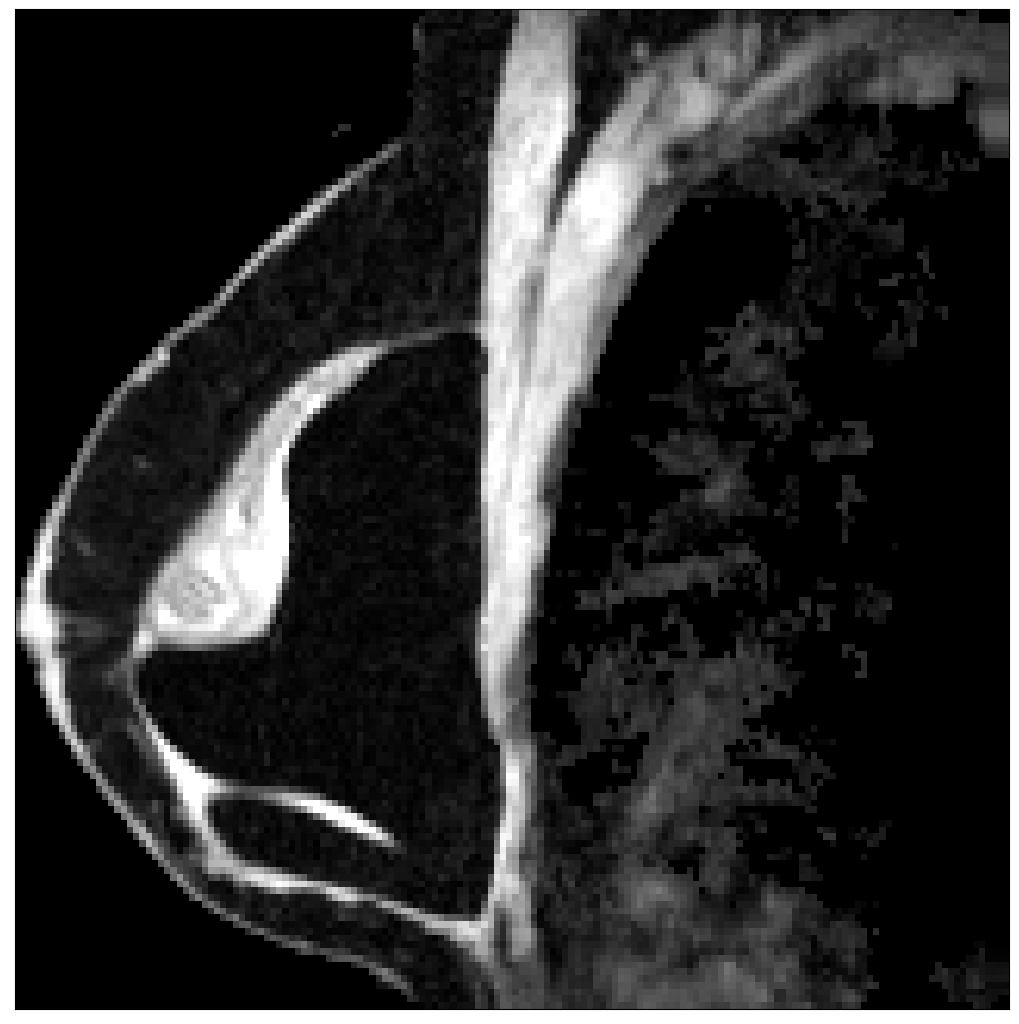

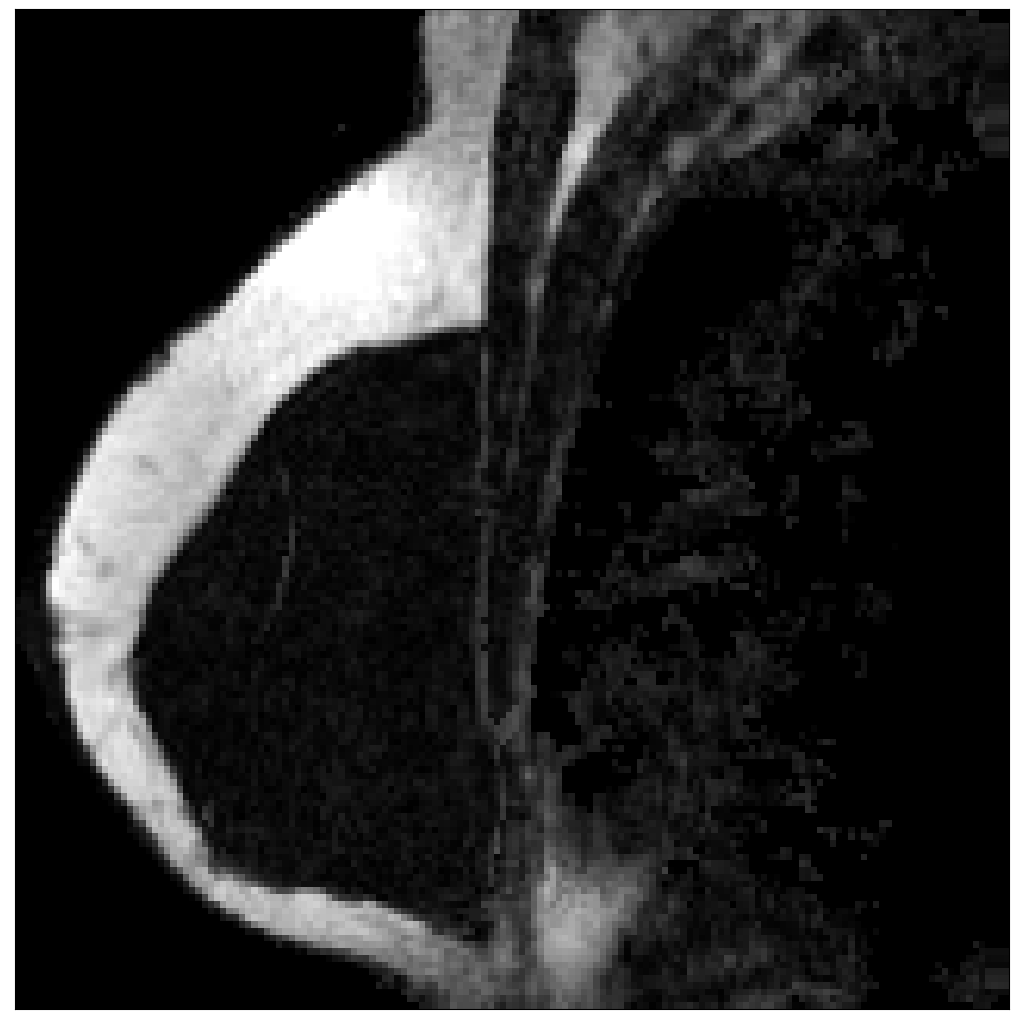

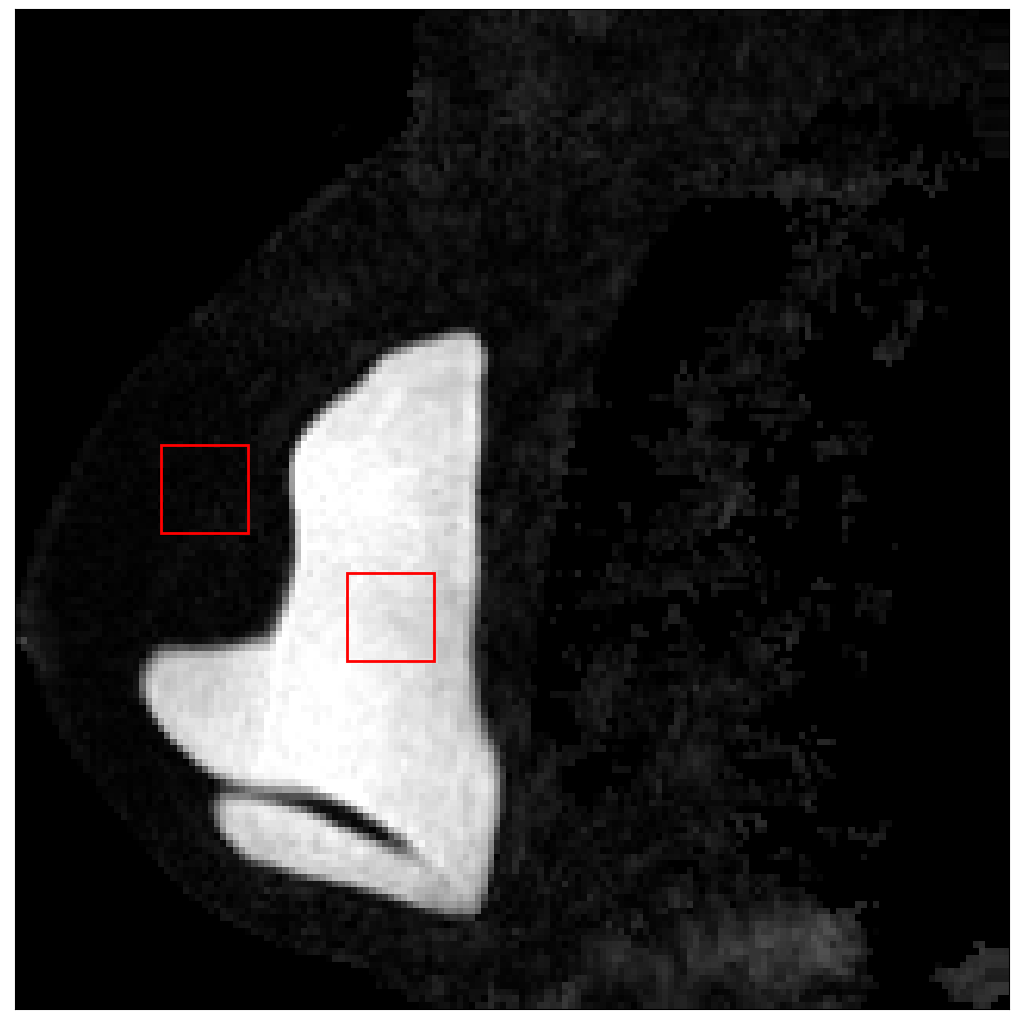

[(1578.1185, 83.691154), (49.399452, 28.177462)]
S/S0: 31.946073532104492


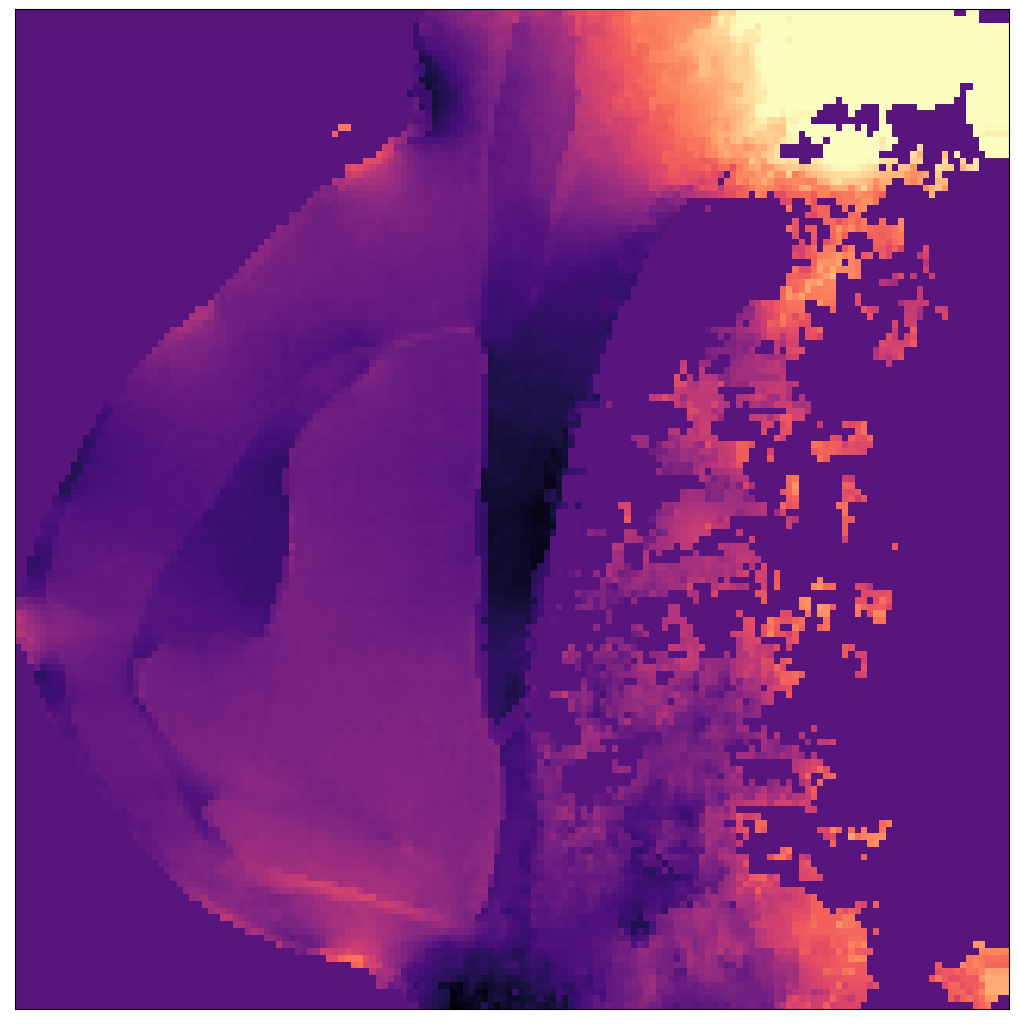

In [12]:
from hmrGC.dixon_imaging.helper import calculate_pdsf_percent

subjects = ['5S']
position3d_multiecho = [[73, 236, 106]]

fig_name = 'invivo_separation'
os.makedirs(f'./figures/{fig_name}', exist_ok=True)

for i, subject in enumerate(subjects):
    source = h5py.File(f'./data/invivo/invivo_{subject}.h5', 'r')
    processed = h5py.File(f'./data/invivo/processed_workstation/processed_{subject}.h5', 'r')
    for echoes_number in ['4 echoes', '6 echoes']:
        num_echoes = int(echoes_number[0])
        mask = get_tissueMaskFilled(source['multiecho'][..., :num_echoes], 10)
        for method in ['breast']:
            for img_type in ['water', 'fat', 'silicone', 'fieldmap']:
                img = np.array(processed[echoes_number][method][img_type])
                img[~mask] = 0
                voxelsize = source['multiecho'].attrs['voxelSize_mm']
                if img_type == 'fieldmap':
                    limits  = [-150, 400]
                else:
                    img = np.abs(img)
                    limits = None #[0,  np.percentile(img, 99)]
                if img_type == 'silicone':
                    patch = [((53, 83), 14, 13), ((23, 64), 14, 13)]
                else:
                    patch = None
            
                filename = f'invivo_{echoes_number[0]}_echoes_{subject}__{method}_{img_type}'
                val_patch = plot_images(img, cmap_img_type[img_type], ['sagittal'], voxelsize, 
                                        position3d_multiecho[i], limits, filename=filename, fig_name=fig_name, 
                                        patch=patch)
                if img_type == 'silicone':
                    print(val_patch)
                    print(f'S/S0: {val_patch[0][0]/val_patch[1][0]}')

## Silicone images (Fig. 10)

[16.18 16.18 60.  ]
[16.73913  16.73913  18.199999]


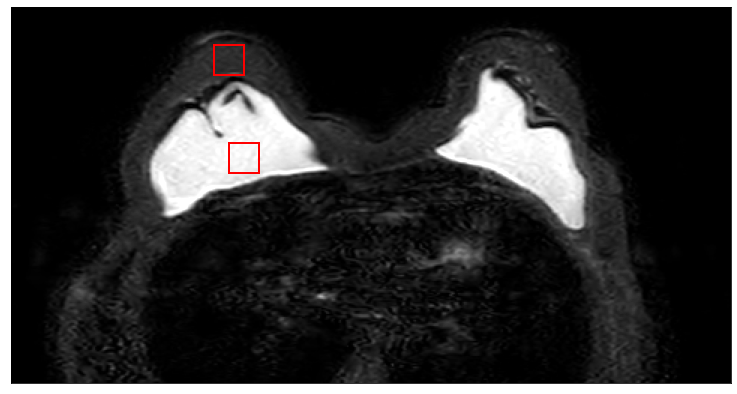

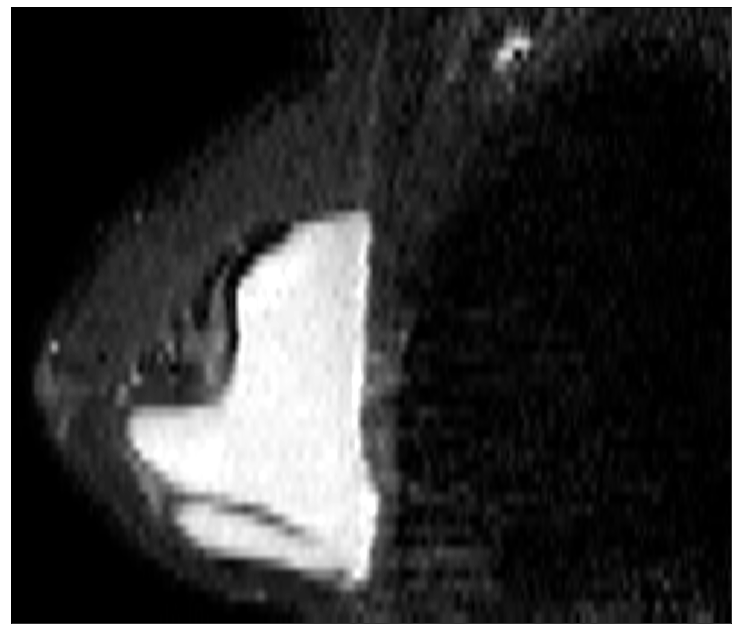

S/S0: 5.294809818267822


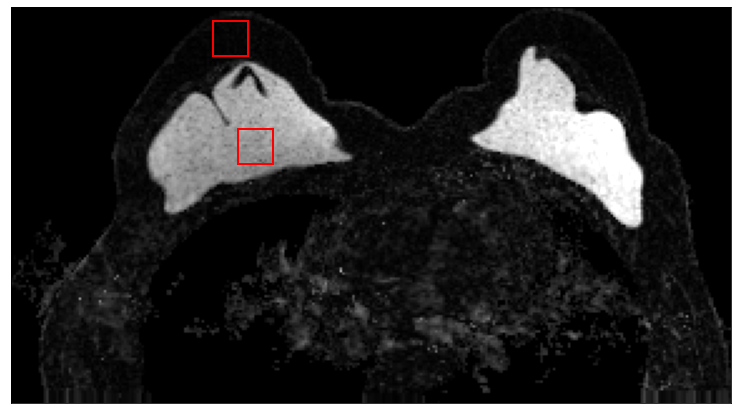

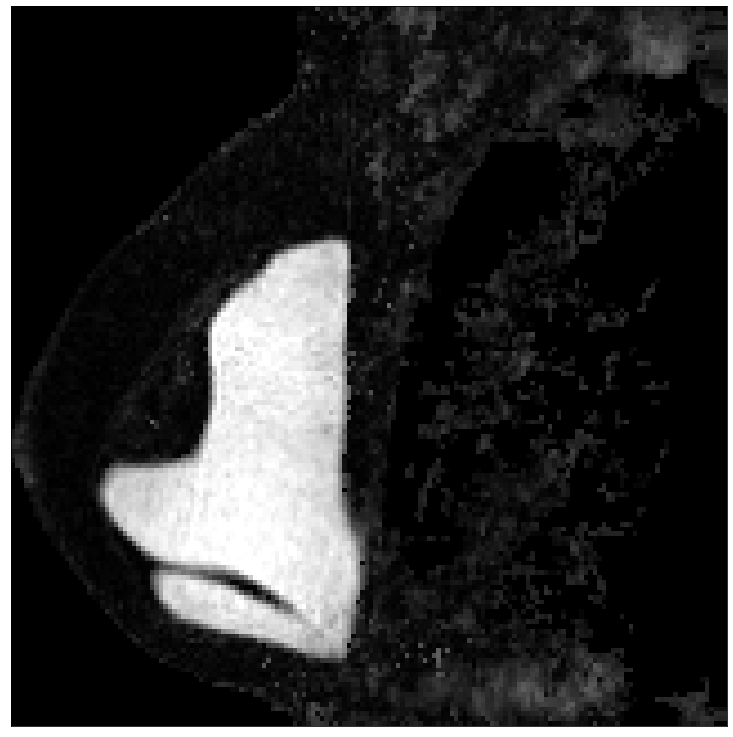

S/S0: 26.227294921875


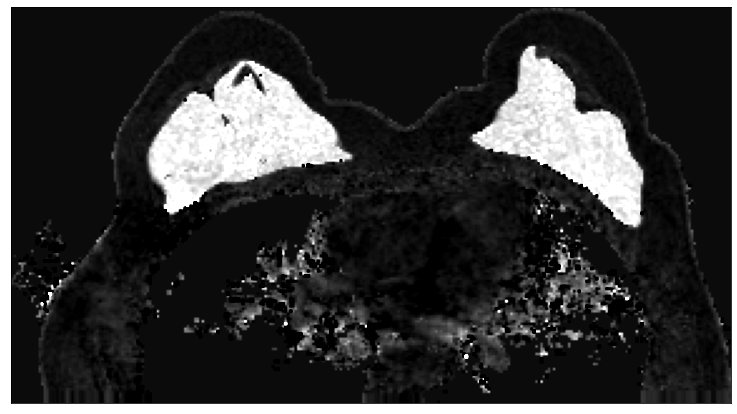

[16.18 16.18 60.  ]
[16.73913  16.73913  18.199999]


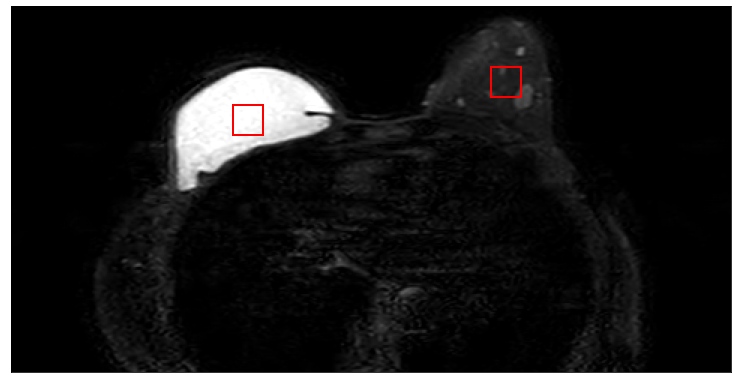

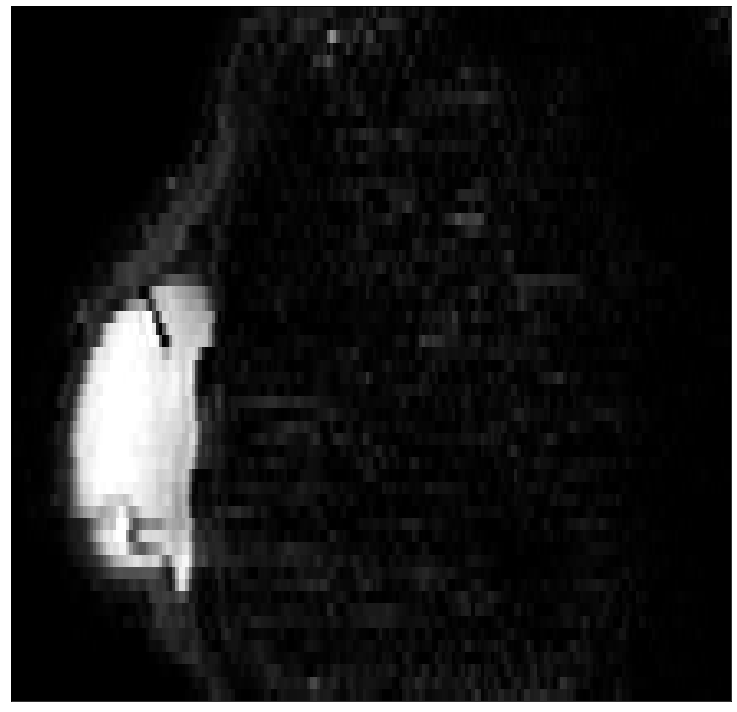

S/S0: 7.08351993560791


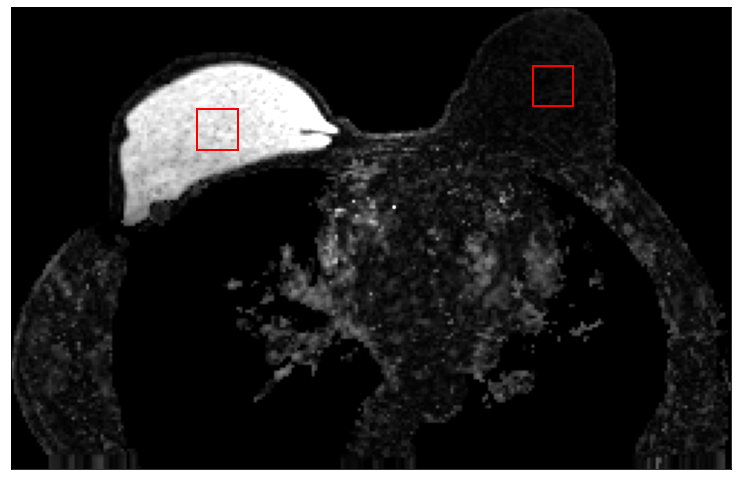

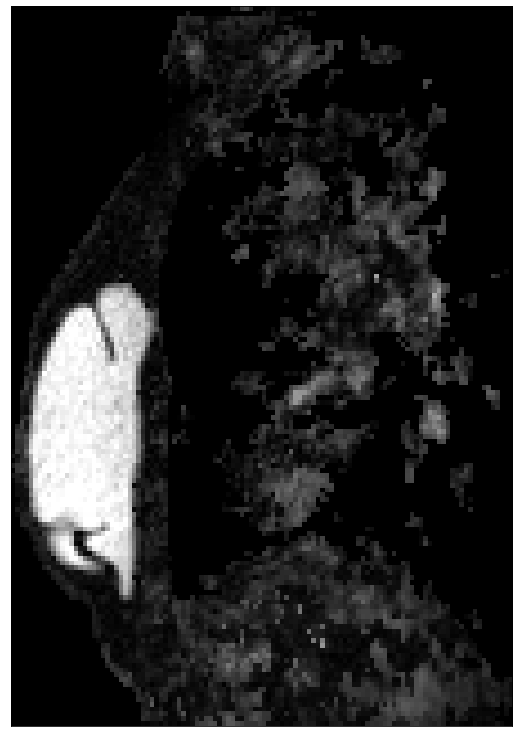

S/S0: 21.036853790283203


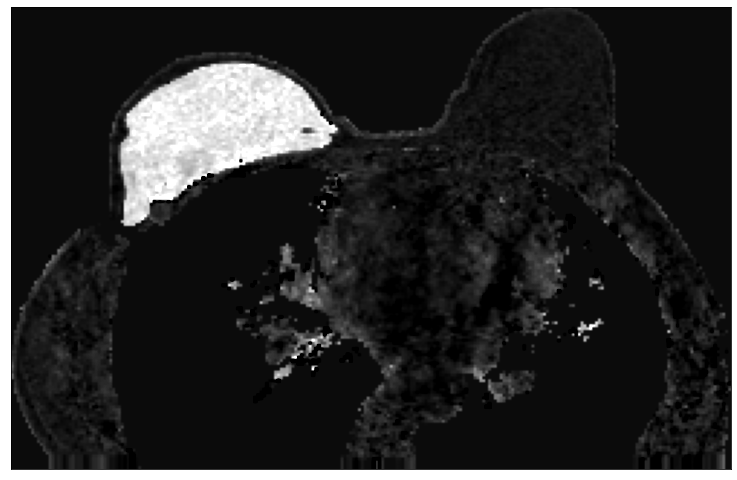

[16.18 16.18 60.  ]
[16.73913  16.73913  18.199999]


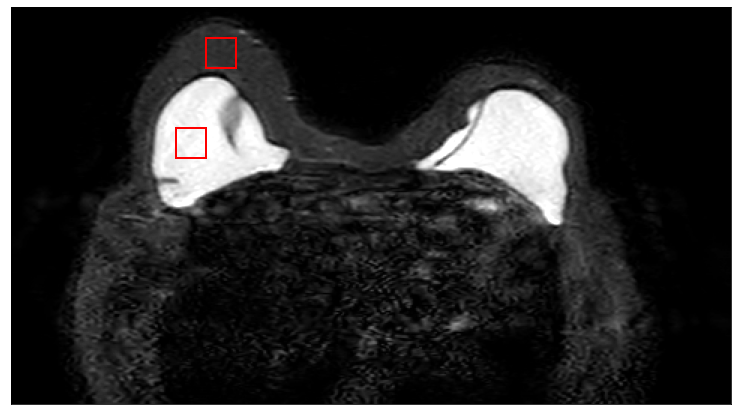

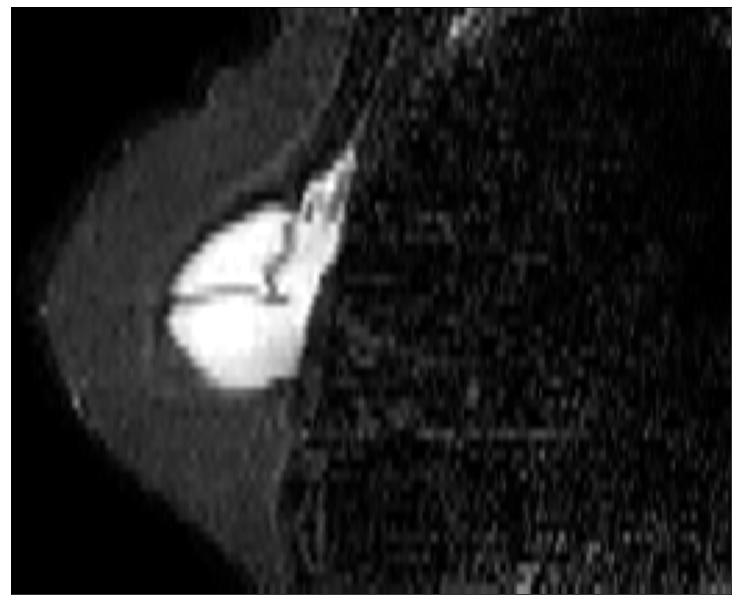

S/S0: 5.1612396240234375


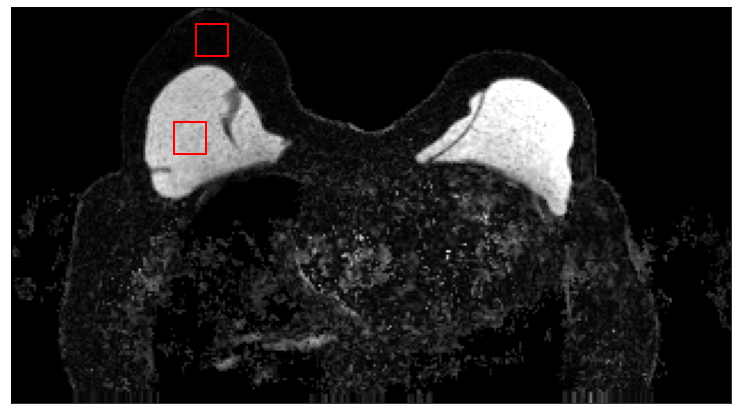

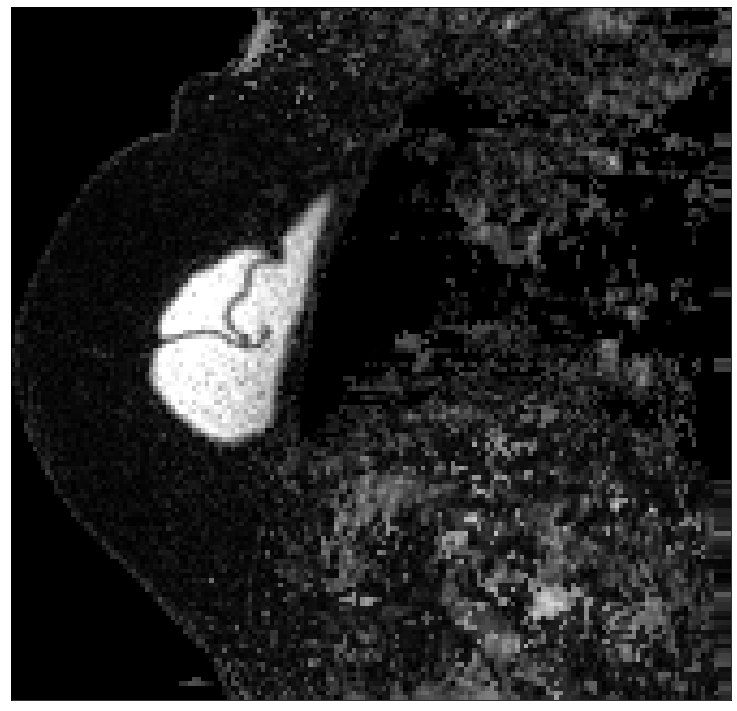

S/S0: 33.82334518432617


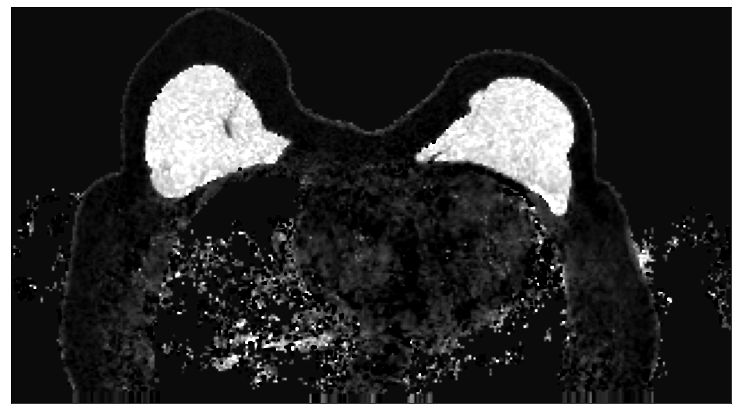

[16.18 16.18 60.  ]
[16.73913  16.73913  18.199999]


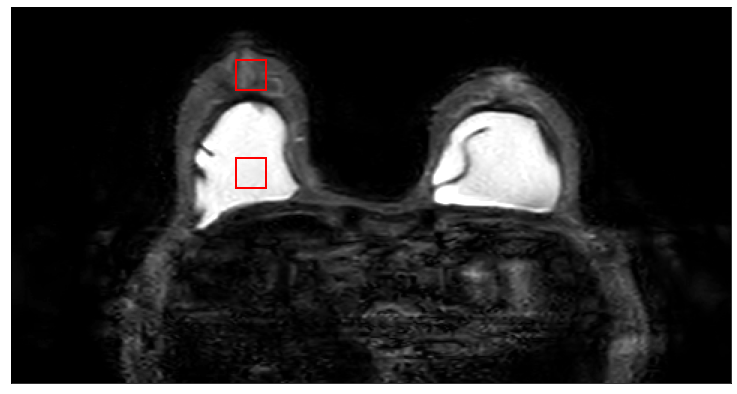

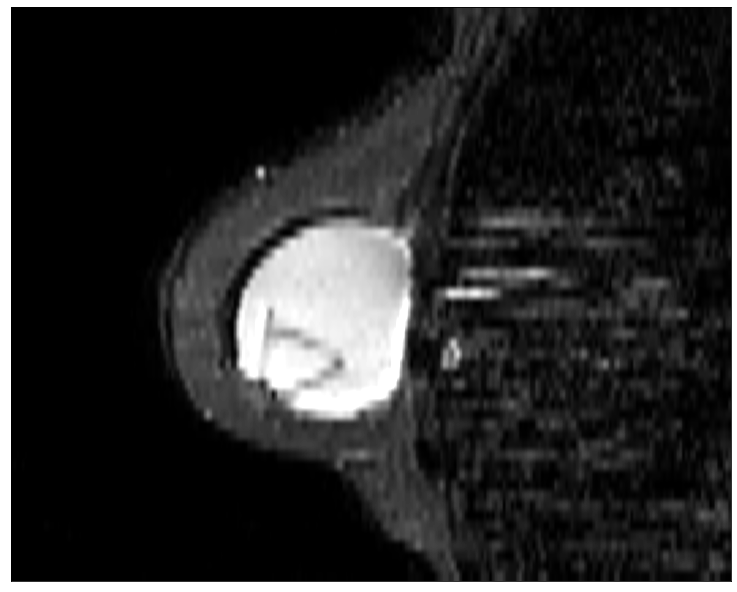

S/S0: 2.974940776824951


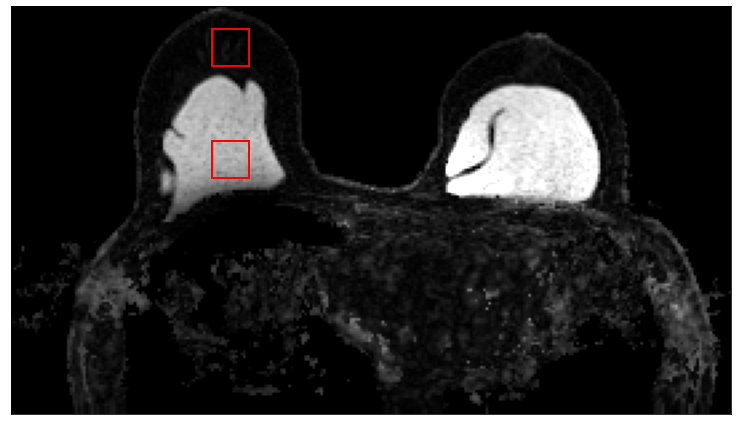

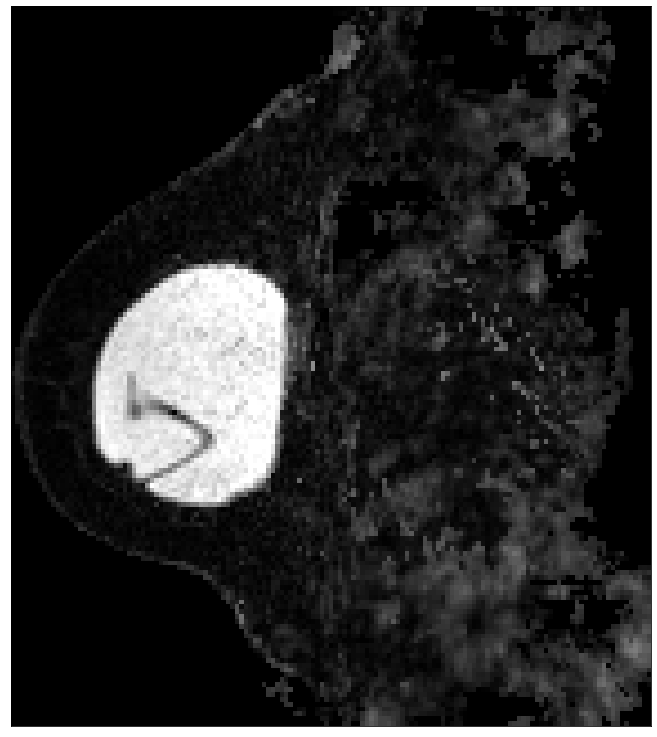

S/S0: 20.337026596069336


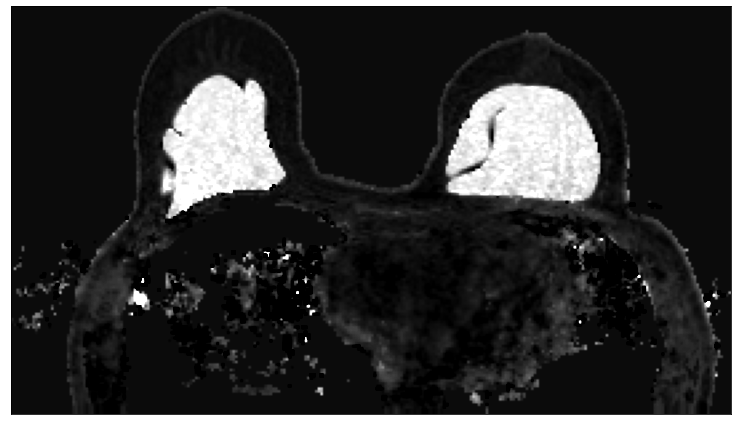

In [79]:
from hmrGC.dixon_imaging.helper import calculate_pdsf_percent

subjects = ['5S', '3S', '2S', '1S']
position3d_multiecho = [[73, 236, 106], [75, 135, 106], [73, 108, 106], [75, 216, 106]]
position3d_silicone_only = [[27, 349, 155], [29, 199, 137], [27, 156, 137], [27, 321, 137]]
patch = [[[((145, 90), 20, 20), ((135, 25), 20, 20)], [((90, 48), 14, 14), ((80, 5), 14, 14)]], 
         [[((148, 65), 20, 20), ((320, 40), 20, 20)], [((64, 35), 14, 14), ((180, 20), 14, 14)]], 
         [[((110, 80), 20, 20), ((130, 20), 20, 20)], [((71, 50), 14, 14), ((81, 7), 14, 14)]], 
         [[((150, 100), 20, 20), ((150, 35), 20, 20)], [((75, 50), 14, 14), ((75, 8), 14, 14)]]]

fig_name = 'invivo_silicone'
os.makedirs(f'./figures/{fig_name}', exist_ok=True)

for i, subject in enumerate(subjects):
    source = h5py.File(f'./data/invivo/invivo_{subject}.h5', 'r')
    processed = h5py.File(f'./data/invivo/processed_workstation/processed_{subject}.h5', 'r')
    for echoes_number in ['4 echoes']:
        num_echoes = int(echoes_number[0])
        mask = get_tissueMaskFilled(source['multiecho'][..., :num_echoes], 10)
        for method in ['breast']:
            for img_type in ['silicone']:
                img = np.array(processed[echoes_number][method][img_type])
                img_siliconeonly = np.abs(np.array(source['silicone_only']))[..., 0]
                img[~mask] = 0
                voxelsize = source['multiecho'].attrs['voxelSize_mm']
                voxelsize_siliconeonly = [0.8090, 0.8090, 3]
                print(np.array(voxelsize_siliconeonly)*20)
                print(voxelsize*14)
                img = np.abs(img)
                limits = None #[0,  np.percentile(img, 99)]
                
                pdsf = calculate_pdsf_percent(np.array(processed[echoes_number][method]['water']),
                                              np.array(processed[echoes_number][method]['fat']),
                                              np.array(processed[echoes_number][method]['silicone']))
                pdsf[~mask] = 0
                
                #from bmrr_wrapper.Visualization.itkutils import show_arr3d
                #show_arr3d(img_siliconeonly)

                filename = f'invivo_siliconeOnly_{subject}'
                val_patch = plot_images(img_siliconeonly, cmap_img_type[img_type], ['axial'], 
                                        voxelsize_siliconeonly, position3d_silicone_only[i], limits, 
                                        filename=filename, fig_name=fig_name, patch=patch[i][0], plot_cmap=False)
                plot_images(img_siliconeonly, cmap_img_type[img_type], ['sagittal'], 
                            voxelsize_siliconeonly, position3d_silicone_only[i], limits, filename=filename, 
                            fig_name=fig_name, plot_cmap=False)
                print(f'S/S0: {val_patch[0][0]/val_patch[1][0]}')
                filename = f'invivo_{echoes_number[0]}_echoes_{subject}__{method}_{img_type}'
                val_patch = plot_images(img, cmap_img_type[img_type], ['axial'], voxelsize, 
                                        position3d_multiecho[i], limits, filename=filename, fig_name=fig_name, 
                                        patch=patch[i][1], plot_cmap=False)
                plot_images(img, cmap_img_type[img_type], ['sagittal'], voxelsize, 
                            position3d_multiecho[i], limits, filename=filename, fig_name=fig_name, plot_cmap=False)
                print(f'S/S0: {val_patch[0][0]/val_patch[1][0]}')
                filename = f'invivo_{echoes_number[0]}_echoes_{subject}__{method}_pdsf'
                plot_images(pdsf, cmap_img_type[img_type], ['axial'], voxelsize, 
                            position3d_multiecho[i], [-5, 105], filename=filename, fig_name=fig_name)

## R2star quantification (Fig. 11)

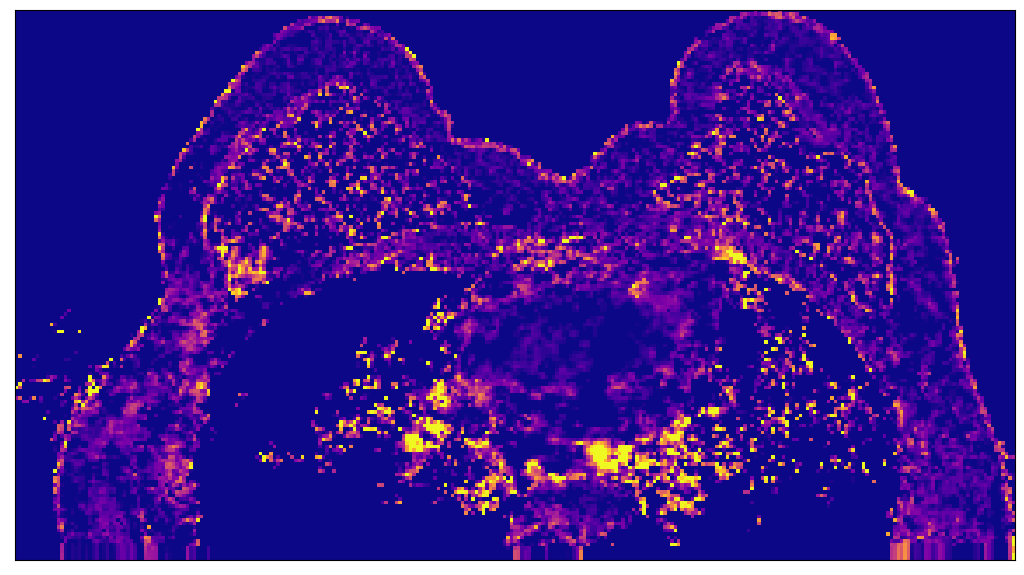

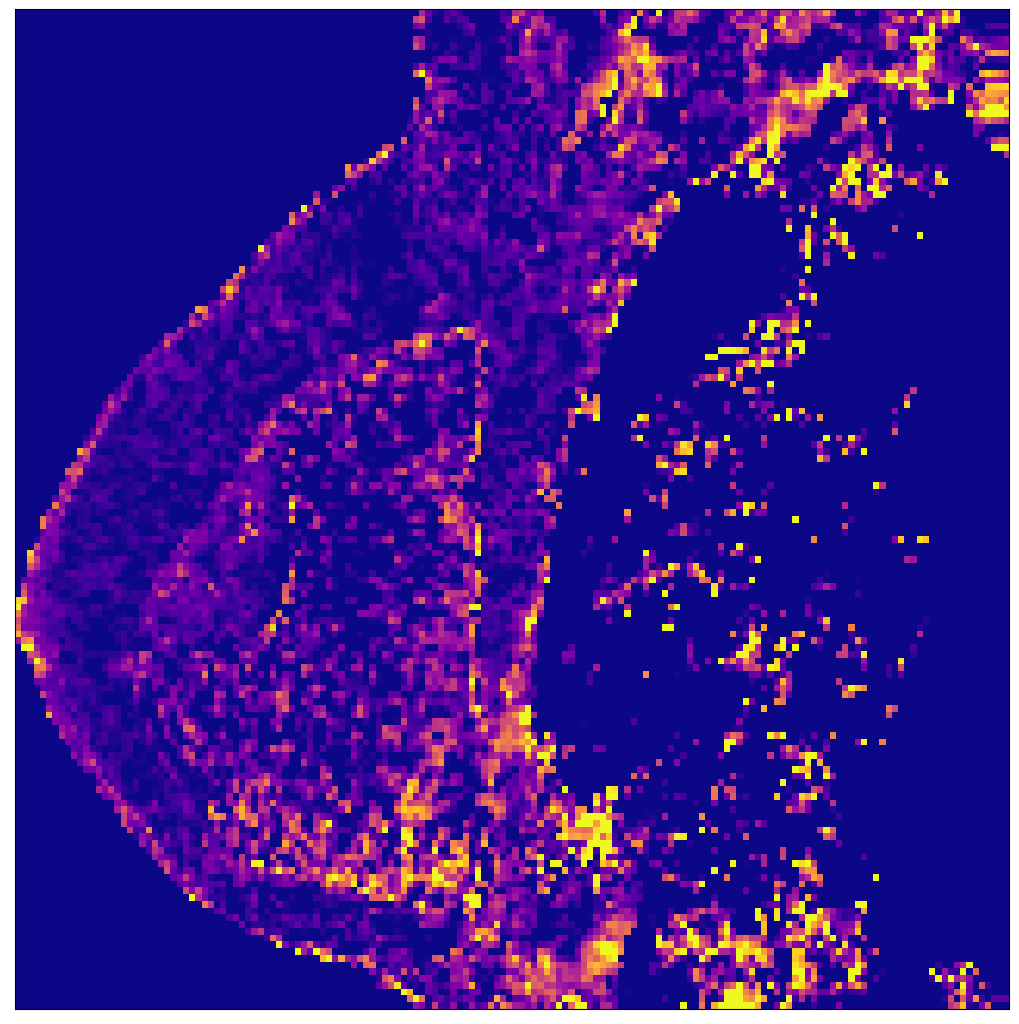

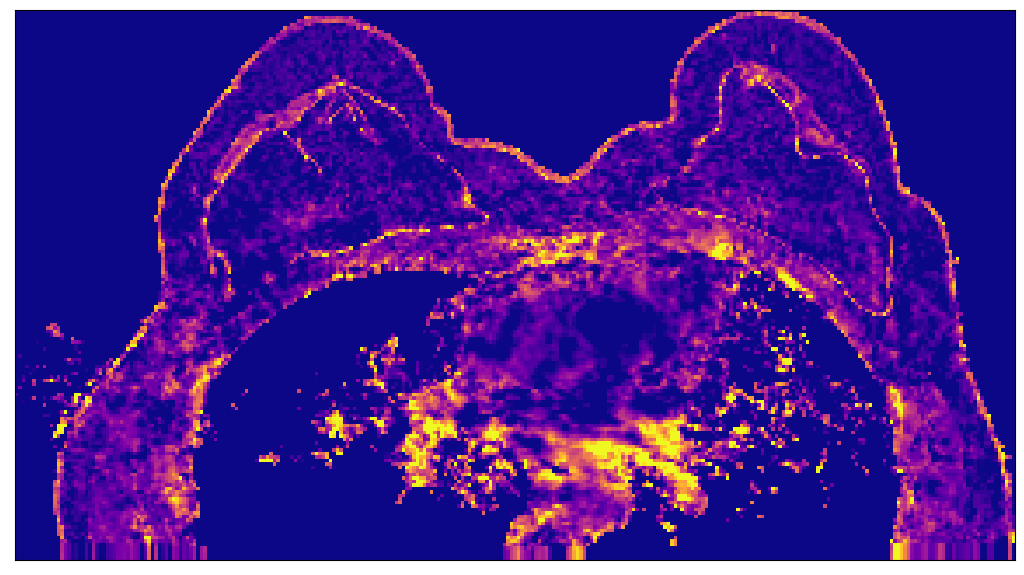

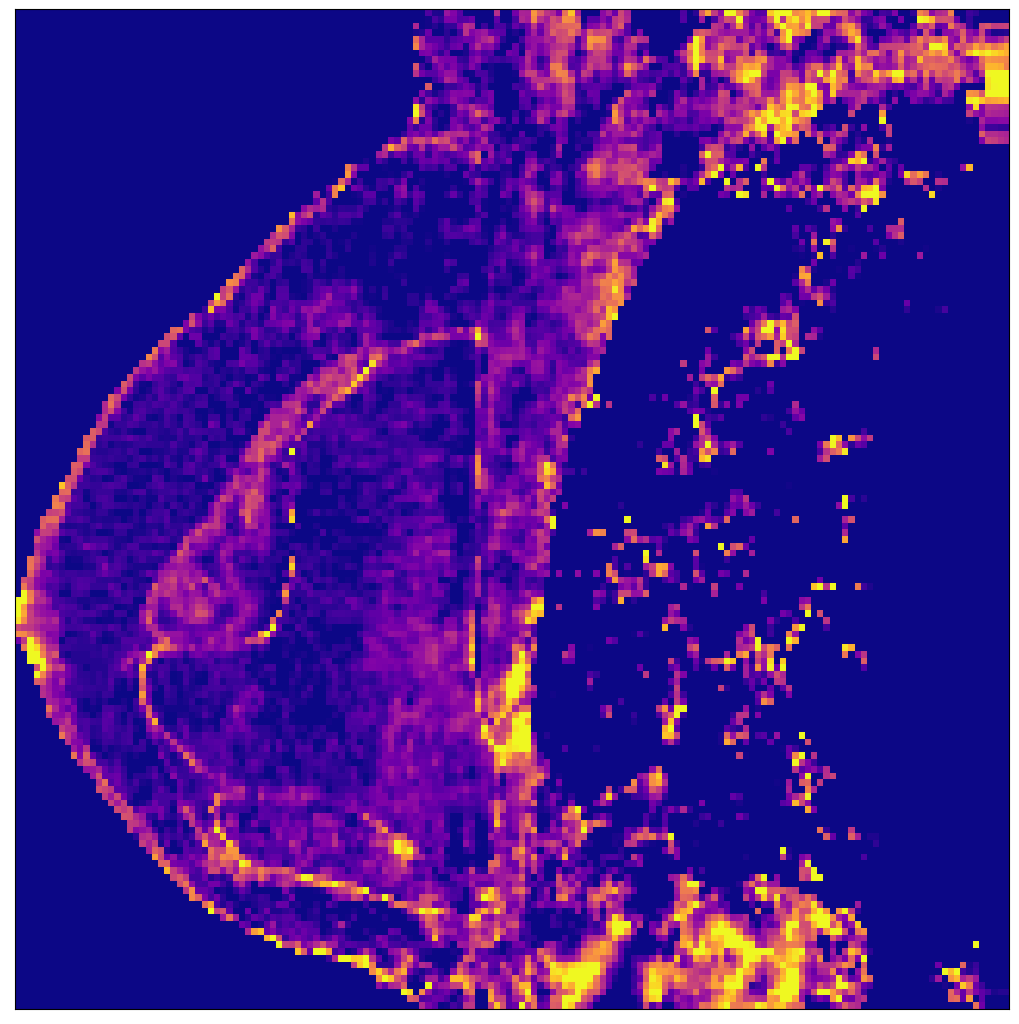

In [14]:
from hmrGC.dixon_imaging.helper import calculate_pdsf_percent

subjects = ['5S']
position3d_multiecho = [[73, 236, 106]]

fig_name = 'r2starmap'
os.makedirs(f'./figures/{fig_name}', exist_ok=True)

for i, subject in enumerate(subjects):
    source = h5py.File(f'./data/invivo/invivo_{subject}.h5', 'r')
    processed = h5py.File(f'./data/invivo/processed_workstation/processed_{subject}.h5', 'r')
    for echoes_number in ['4 echoes', '6 echoes']:
        num_echoes = int(echoes_number[0])
        mask = get_tissueMaskFilled(source['multiecho'][..., :num_echoes], 10)
        for method in ['breast']:
            for img_type in ['r2starmap']:
                img = np.array(processed[echoes_number][method][img_type])
                img[~mask] = 0
                voxelsize = source['multiecho'].attrs['voxelSize_mm']
                img = np.abs(img)
                limits = None #[0,  np.percentile(img, 99)]
                
                pdsf = calculate_pdsf_percent(np.array(processed[echoes_number][method]['water']),
                                              np.array(processed[echoes_number][method]['fat']),
                                              np.array(processed[echoes_number][method]['silicone']))
                pdsf[~mask] = 0

                filename = f'invivo_{echoes_number[0]}_echoes_{subject}__{method}_{img_type}'
                plot_images(img, cmap_img_type[img_type], ['axial', 'sagittal'], voxelsize, 
                            position3d_multiecho[i], limits, filename=filename, fig_name=fig_name)

## PDFF quantification (Fig. 12)

In [17]:
subjects = ['3S', '8S']
fig_name = 'invivo_pdff'
os.makedirs(f'./figures/{fig_name}', exist_ok=True)

pdff_wf = {}
for i, subject in enumerate(subjects):
    source = h5py.File(f'./data/invivo/invivo_{subject}.h5', 'r')
    processed = h5py.File(f'./data/invivo/processed_workstation/processed_{subject}.h5', 'r')
    
    signal = source['multiecho'][..., :4]
    mip = np.sqrt(np.sum(np.abs(signal)**2, axis=-1))
    mask = mip > 7.5 / 100 * np.max(mip)
    
    signal = signal[:, 170:, :, :]
    mask = mask[:, 170:, :]
    params = {}
    params.update(source['multiecho'].attrs)
    params['TE_s'] = params['TE_s'][:4]
    params['FatModel'] = fatmodel

    g = MultiEcho(signal, mask, params)
    g.range_fm *= 2.5/2
    g.r2star_correction = False
    g.perform('multi-res')
    pdff_wf[subject] = g.images['fatFraction_percent']

Multi-echo method: multi-res
1/5: Unwrapping... 

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


done! (8.29s)
2/5: Mid-res... done! (45.68s)
3/5: High-res... done! (26.05s)
4/5: R2starmap... done! (20.7s)
5/5: Images... done! (1.41s)
Multi-echo method: multi-res
1/5: Unwrapping... done! (4.2s)
2/5: Mid-res... done! (46.32s)
3/5: High-res... done! (29.99s)
4/5: R2starmap... done! (26.23s)
5/5: Images... done! (1.55s)


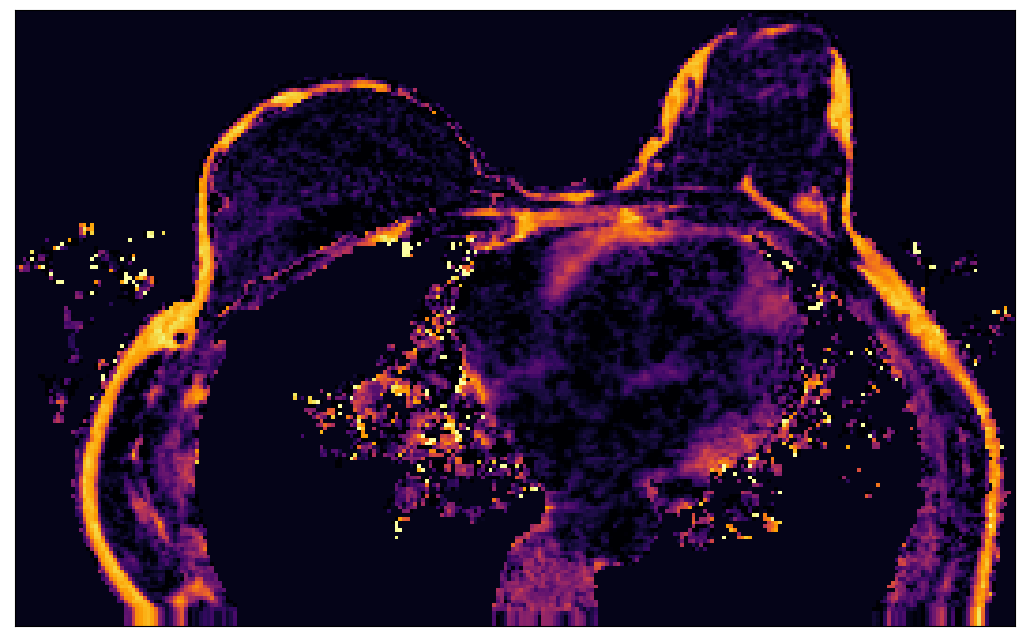

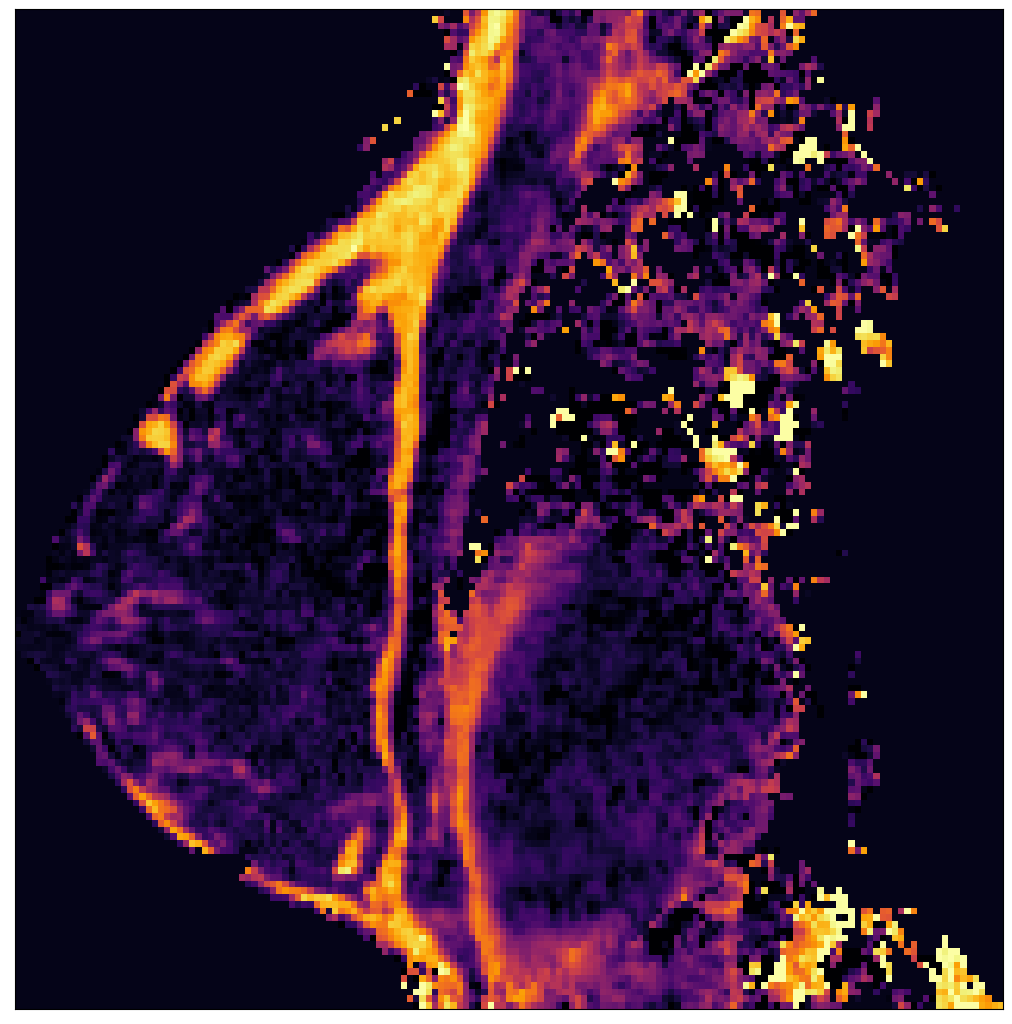

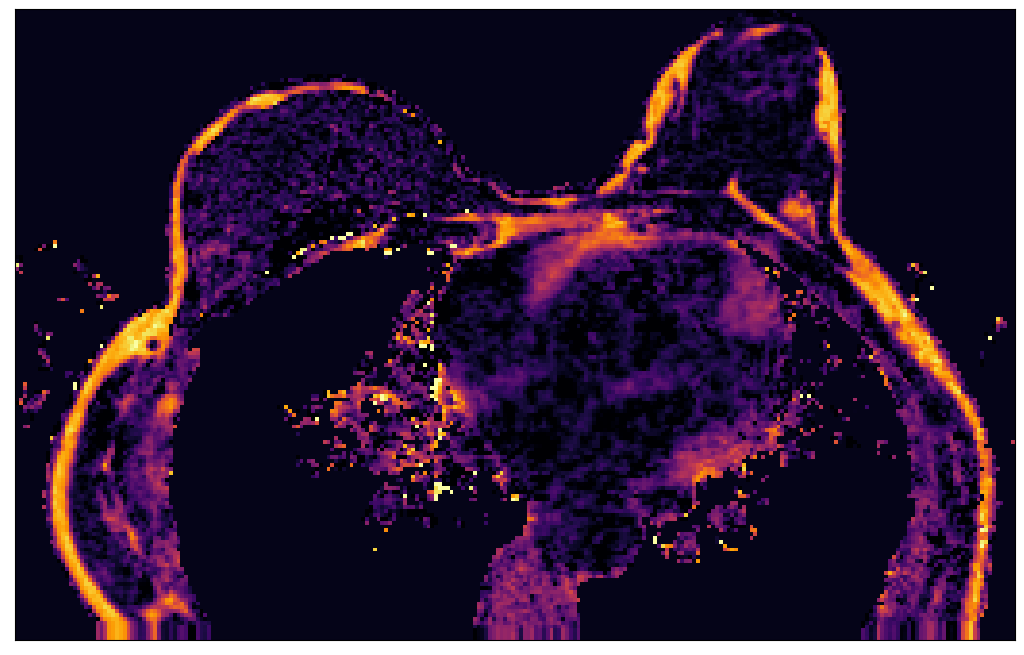

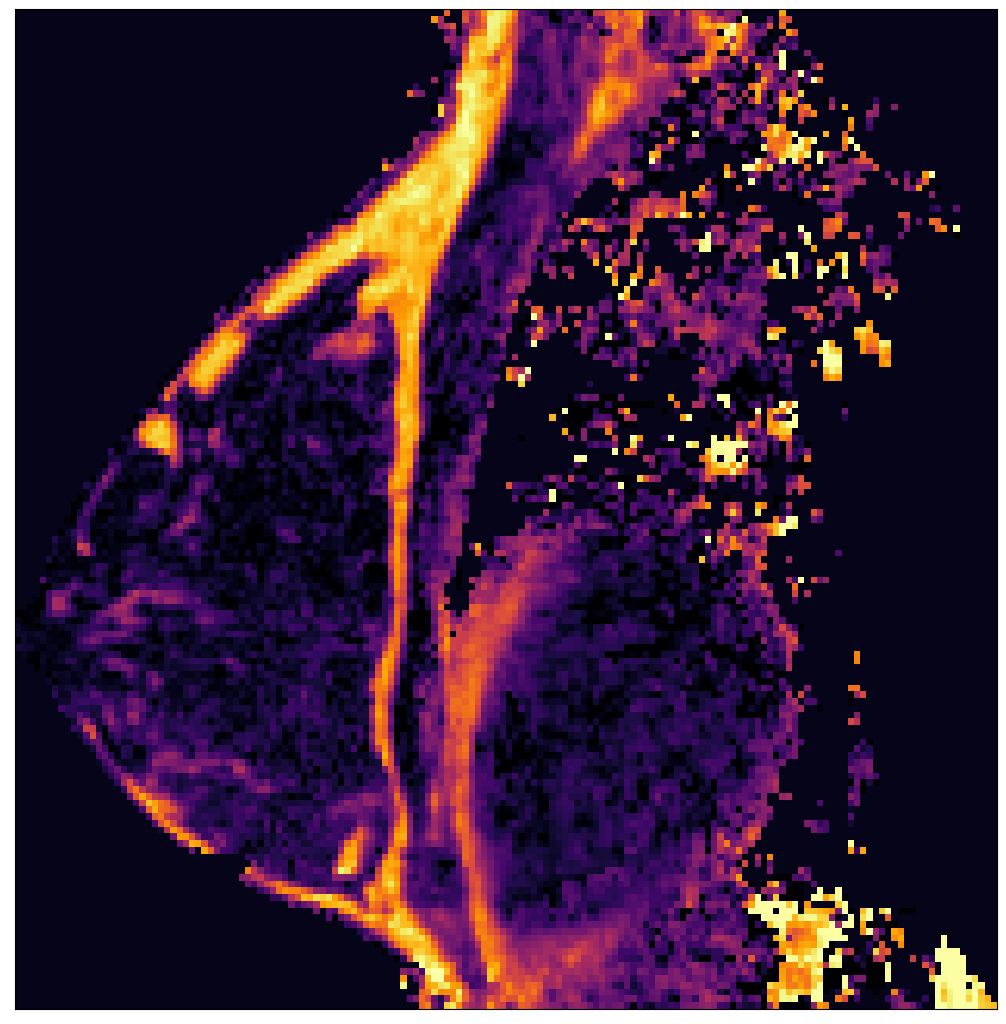

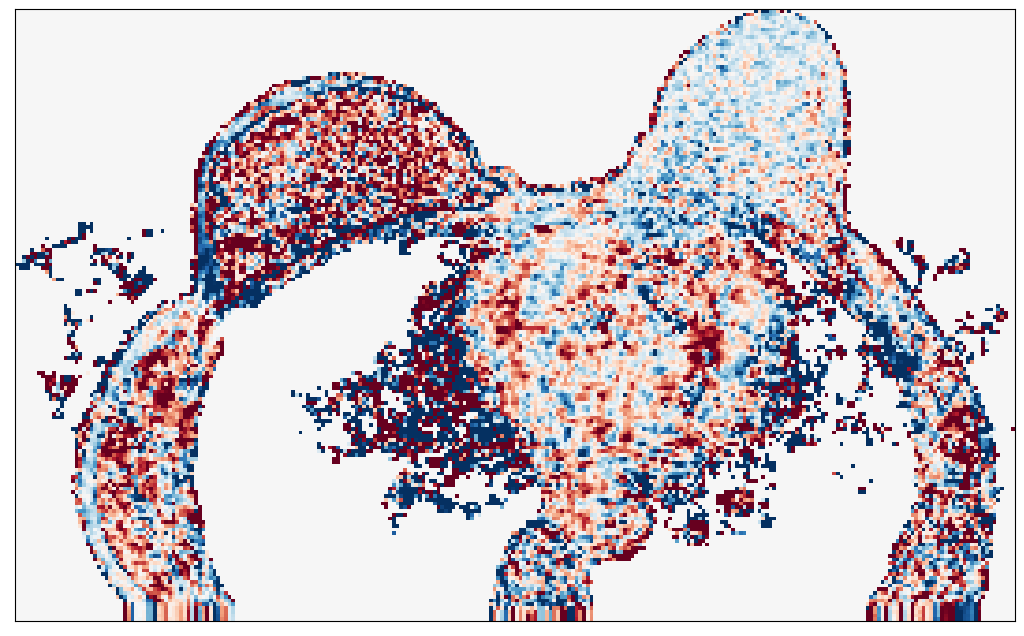

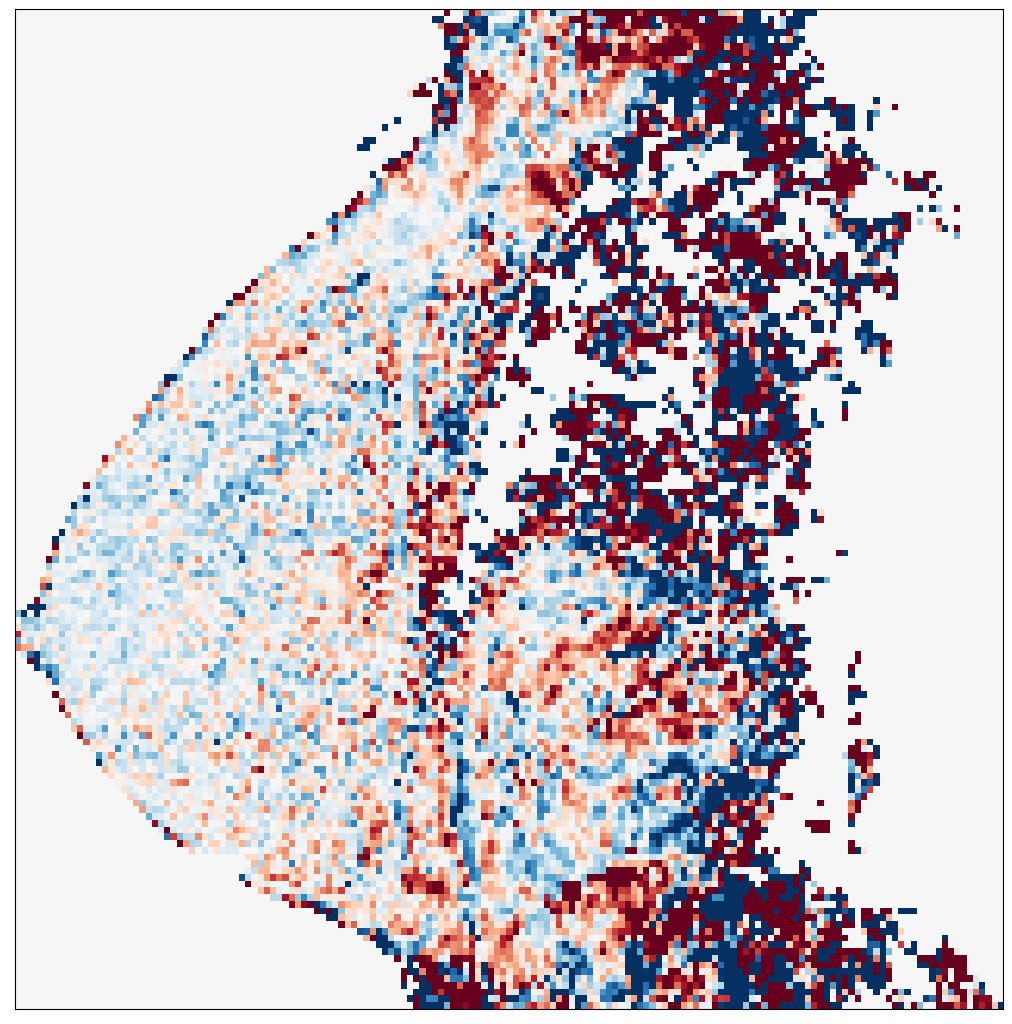

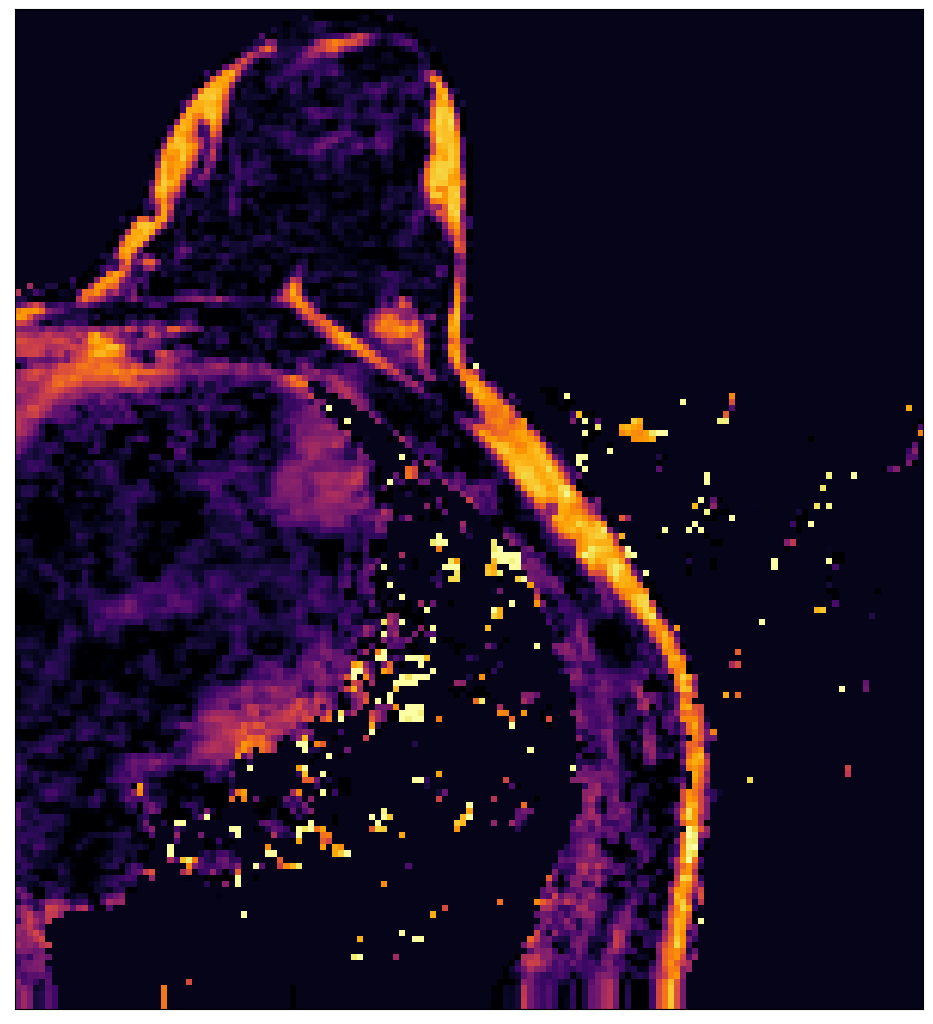

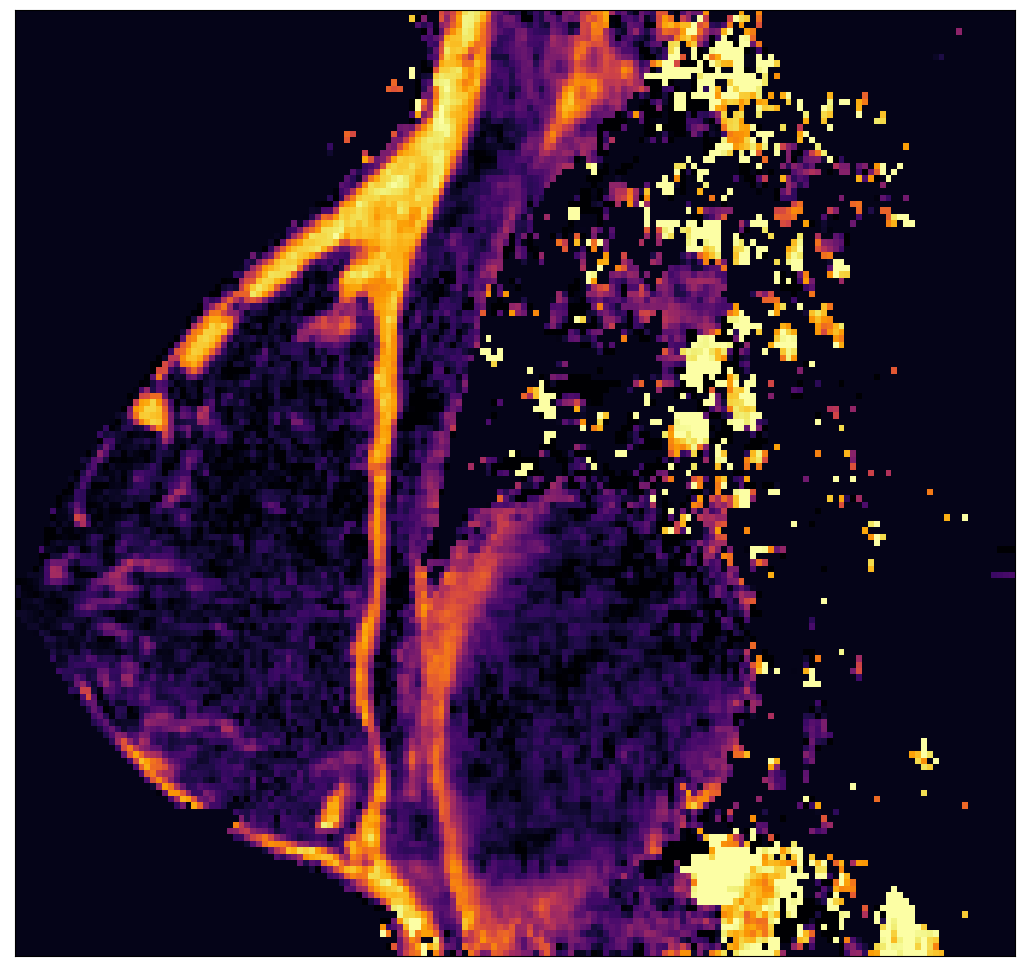

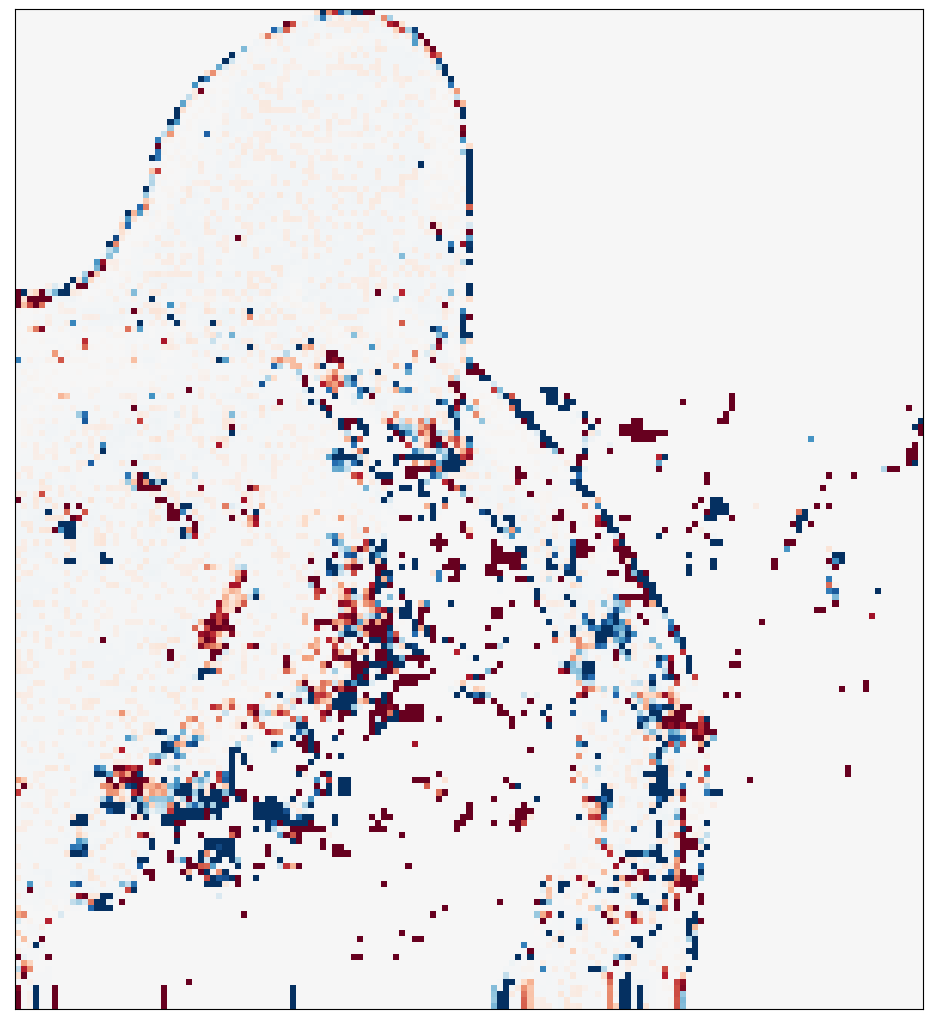

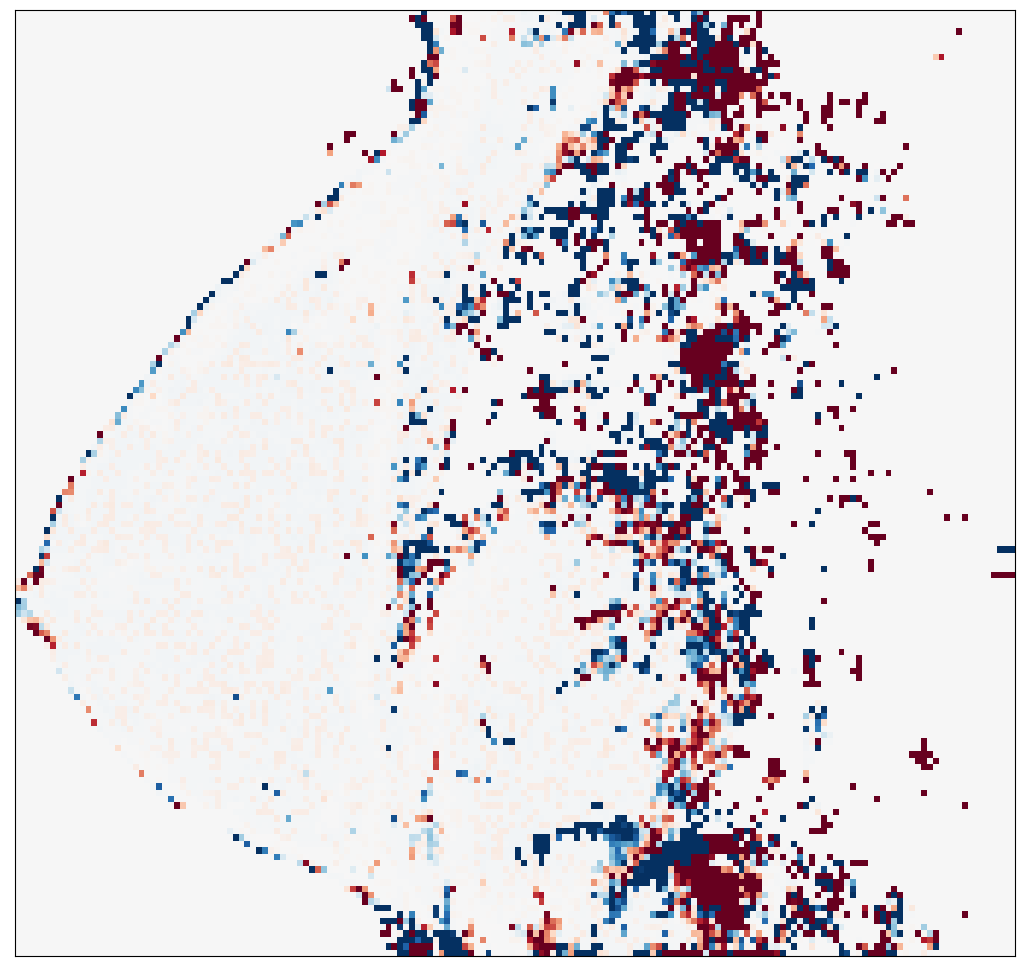

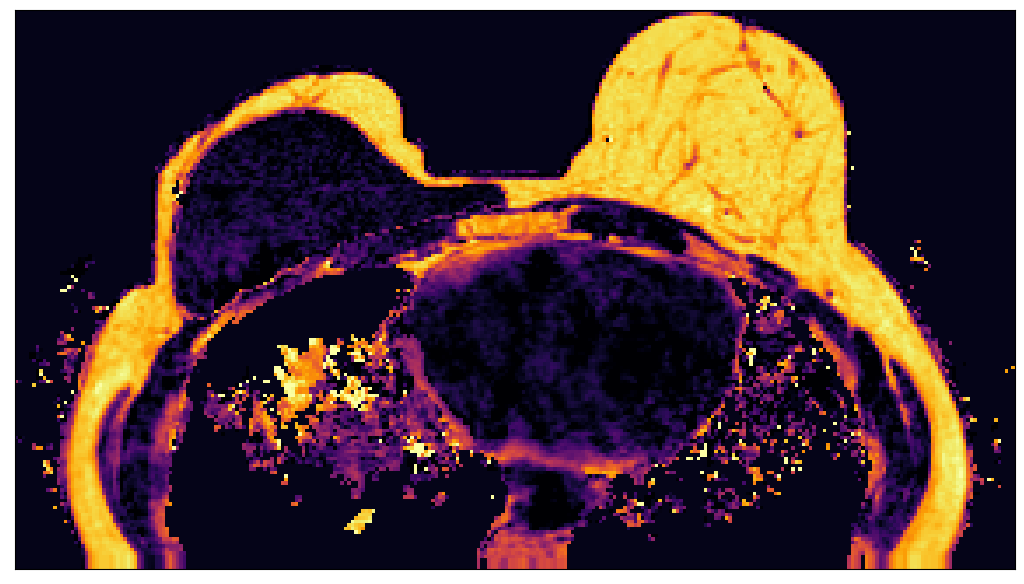

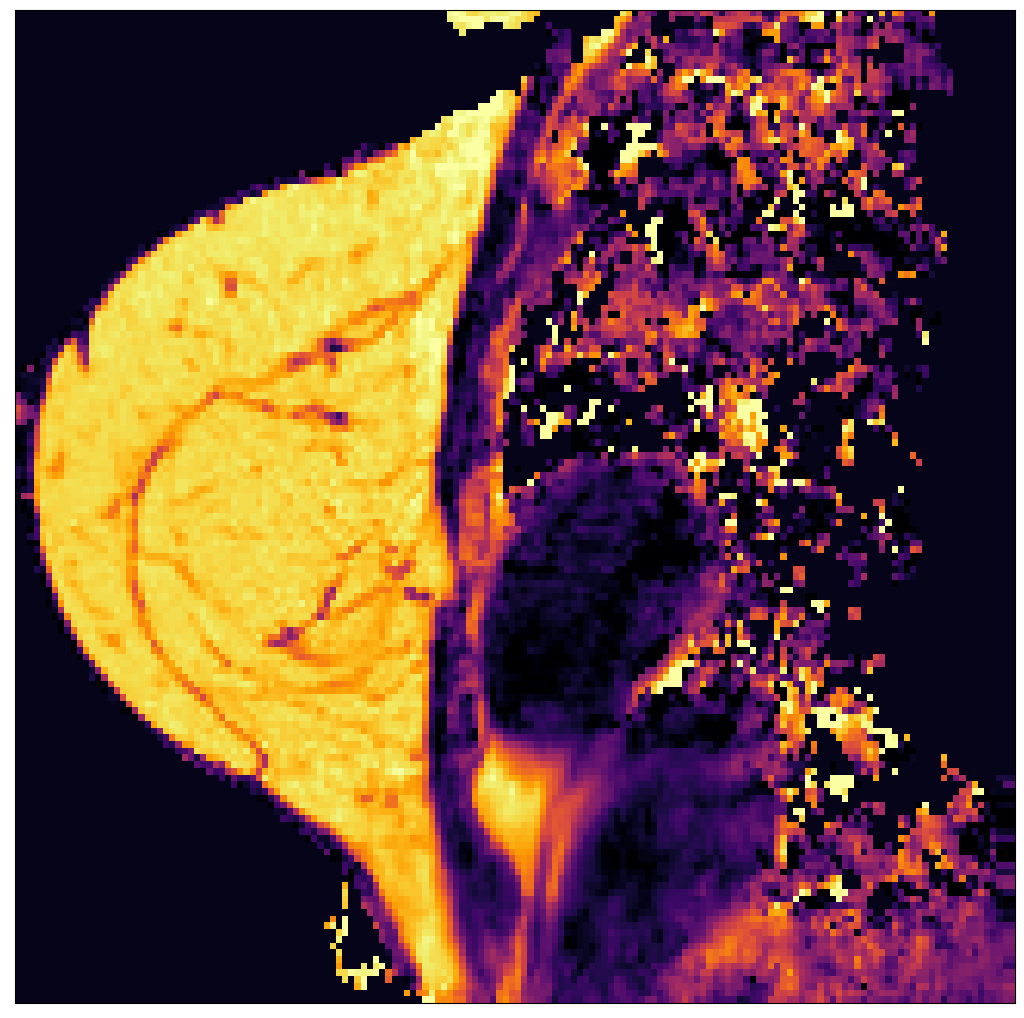

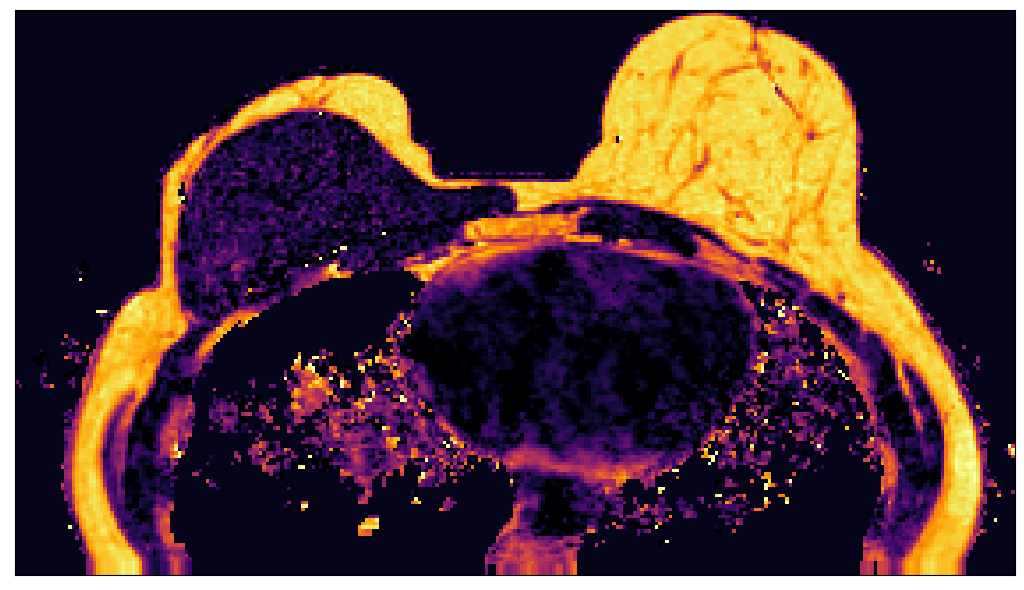

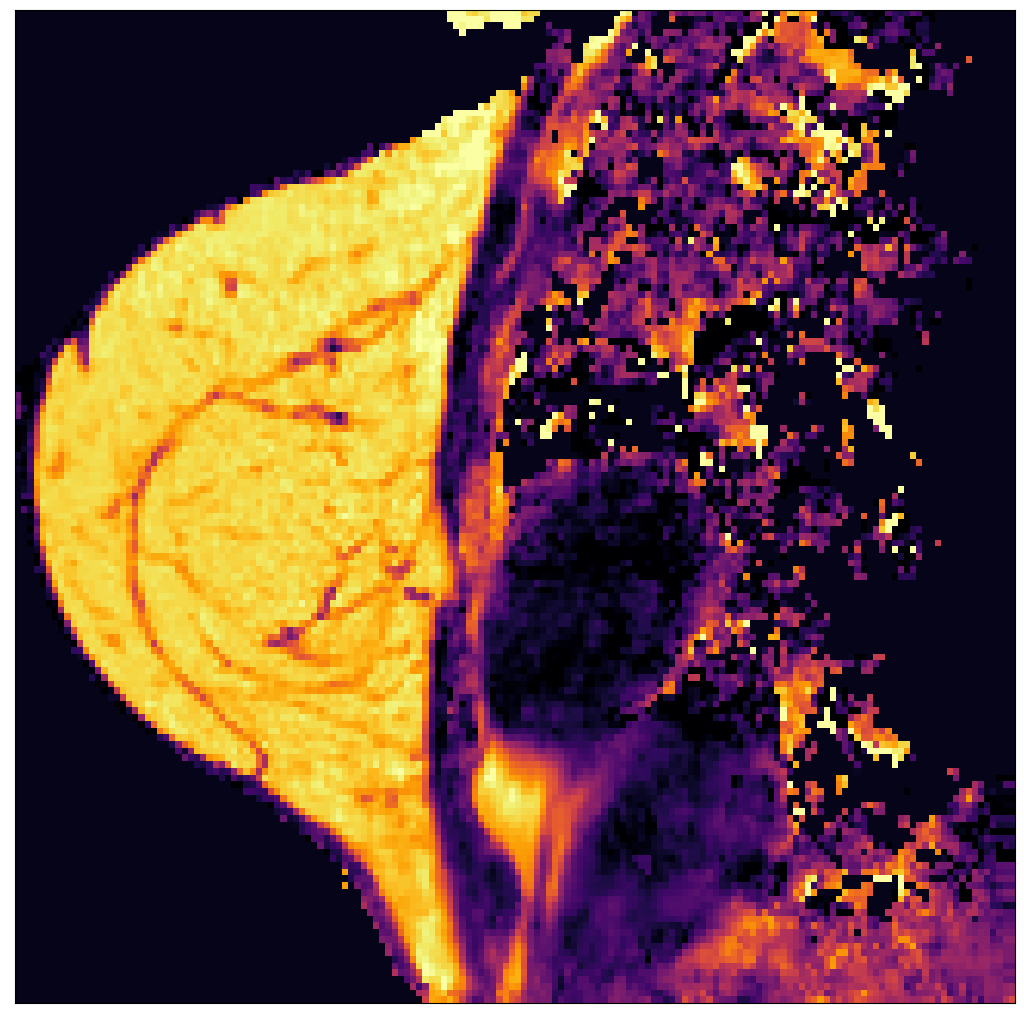

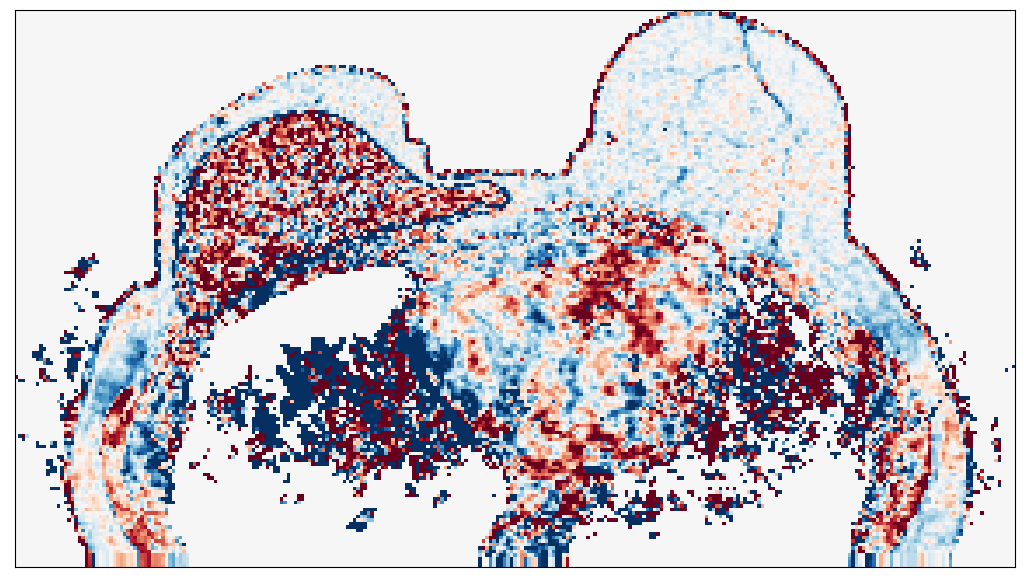

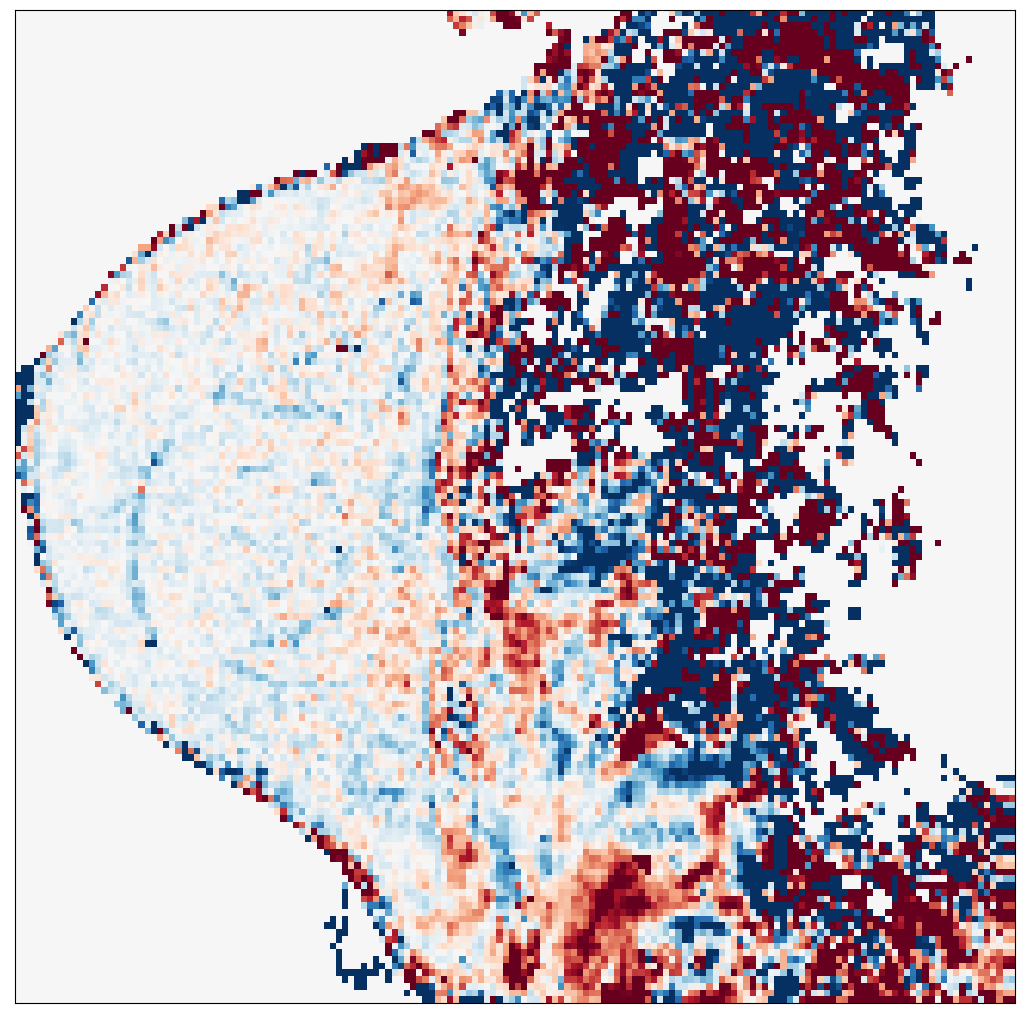

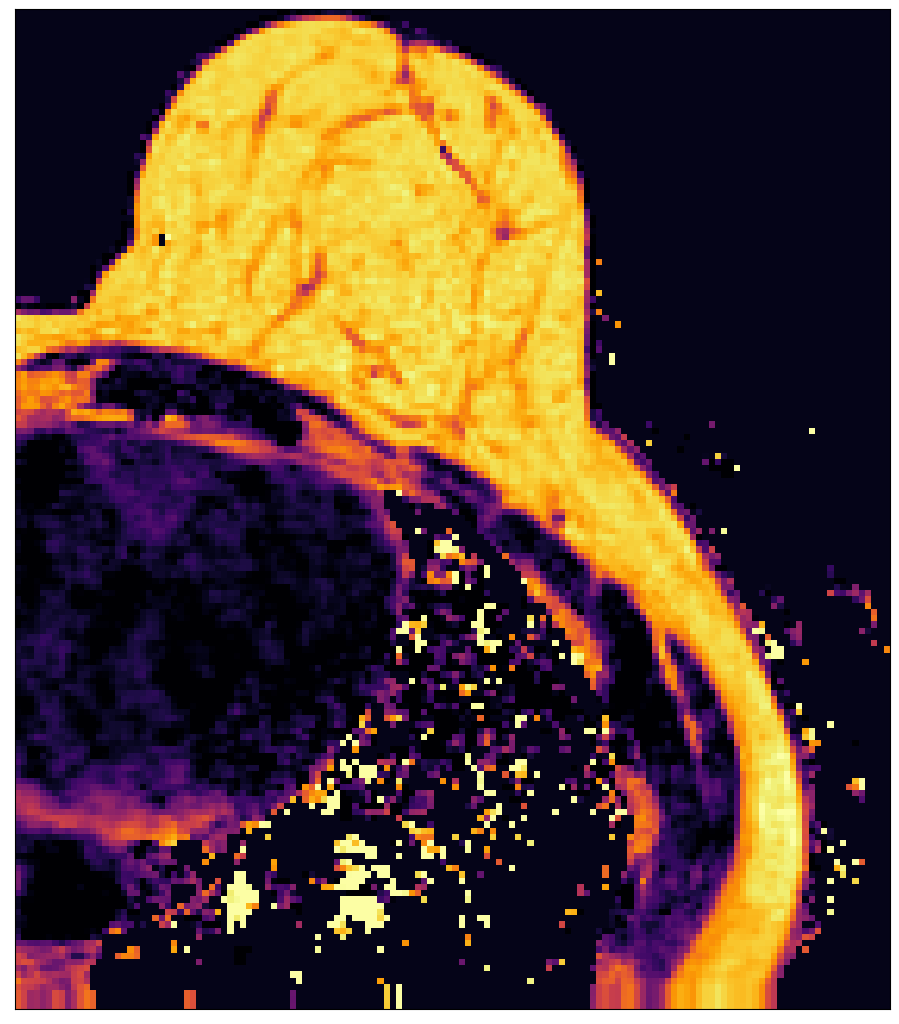

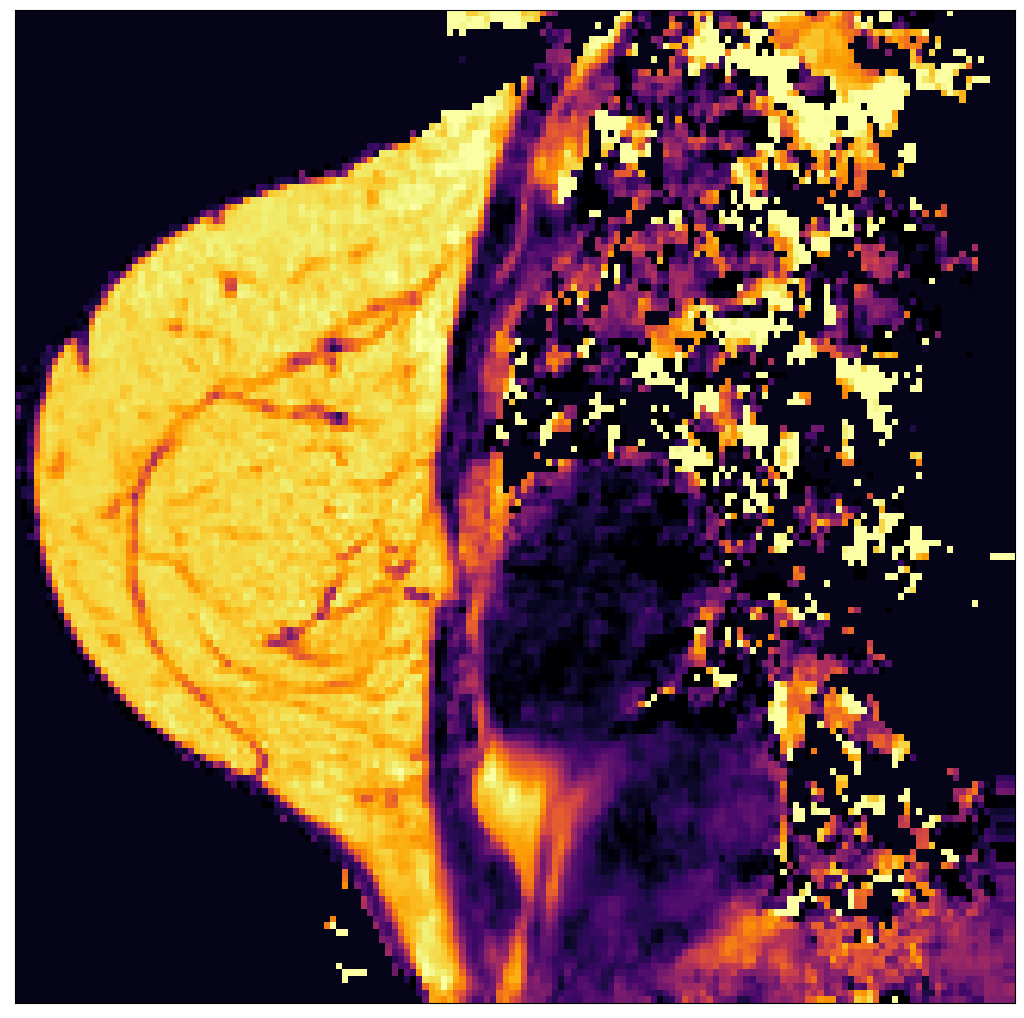

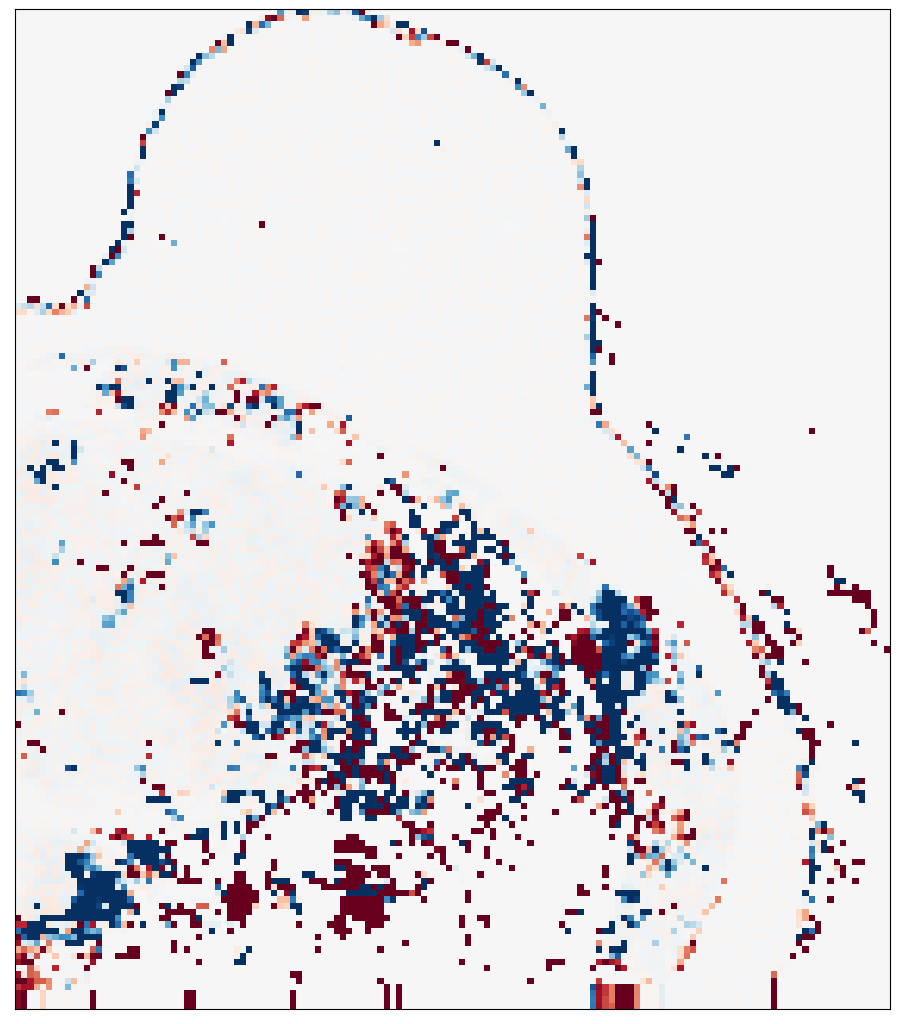

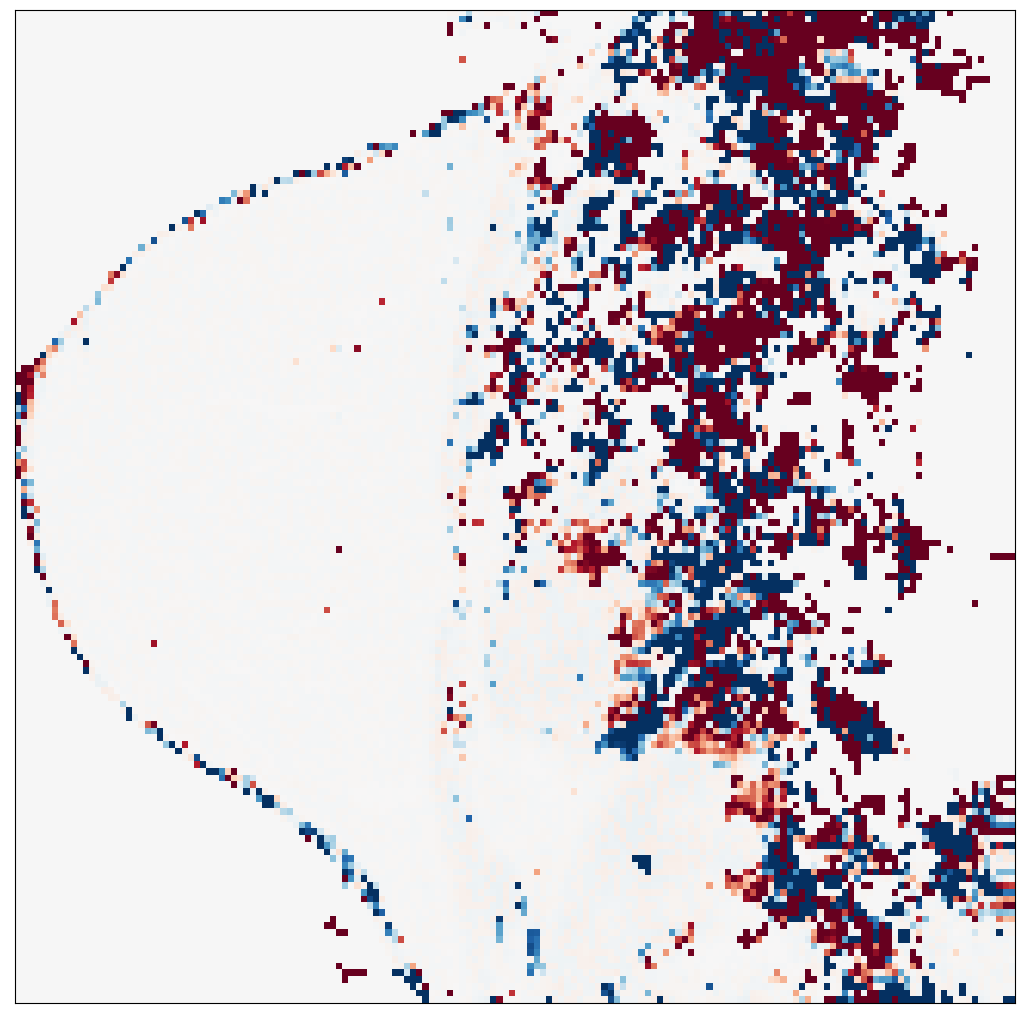

In [18]:
position3d = [[68, 226, 106], [68, 226, 106]]
fig_name = 'invivo_pdff'
os.makedirs(f'./figures/{fig_name}', exist_ok=True)

for i, subject in enumerate(subjects):
    source = h5py.File(f'./data/invivo/invivo_{subject}.h5', 'r')
    processed = h5py.File(f'./data/invivo/processed_workstation/processed_{subject}.h5', 'r')
    for echoes_number in ['6 echoes', '4 echoes']:
        num_echoes = int(echoes_number[0])
        mask = get_tissueMaskFilled(source['multiecho'][..., :num_echoes], 7.5)
        for method in ['breast']:
            for img_type in ['fatFraction_percent']:
                img = np.array(processed[echoes_number][method][img_type])
                img[~mask] = 0
                voxelsize = source['multiecho'].attrs['voxelSize_mm']
                limits = [-5, 105] #[0,  np.percentile(img, 99)]
                filename = f'invivo_{echoes_number[0]}_echoes_{subject}__{method}_{img_type}'
                plot_images(img, cmap_img_type[img_type], ['axial', 'sagittal'], voxelsize, 
                            position3d[i], limits, filename=filename, fig_name=fig_name)
        
        # difference images:
        if echoes_number == '4 echoes':
            diff -= img
            filename = f'invivo_diff_echoes_{subject}_{img_type}'
            plot_images(diff, 'RdBu', ['axial', 'sagittal'], voxelsize, 
                        position3d[i], [-10, 10], filename=filename, fig_name=fig_name)
            
            img_wf = np.zeros_like(img)
            img_wf[:, 170:, :] = pdff_wf[subject]
            
            filename = f'invivo_{echoes_number[0]}_echoes_{subject}__multi-resWF_{img_type}'
            plot_images(img_wf, cmap_img_type[img_type], ['axial', 'sagittal'], voxelsize, 
                        position3d[i], limits, filename=filename, fig_name=fig_name)
            
            diff_wf = np.zeros_like(img)
            diff_wf[:, 170:, :] = img[:, 170:, :] - pdff_wf[subject] 
            
            filename = f'invivo_diff_signal_model_{subject}_{img_type}'
            plot_images(diff_wf, 'RdBu', ['axial', 'sagittal'], voxelsize, 
                        position3d[i], [-10, 10], filename=filename, fig_name=fig_name)
        else:
            diff = img